In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
# %matplotlib nbagg
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib import rcParams  # Para aumentar la resolución de los gráficos de Matplot
%config InlineBackend.figure_format='retina'
rcParams['font.family'] = 'serif'
rcParams["font.size"] = 14
rcParams['figure.figsize'] = (12, 6)
rcParams['figure.dpi'] = 100
plt.style.use('seaborn-dark-palette')

In [42]:
def rankine(x,omega,c): # Hay que chequearla porque no se si funciona bien
    f = []
    for i in x:
        if i < c:
            f.append(omega*i)
        else:
            f.append((omega*c**2)/i)
    return np.array(f)

def rankine2(x,omega,c):
    return np.piecewise(x,[x<c, x>=c], [lambda x: omega*x, lambda x: (omega*c**2)/x])

def burgers(x,a,b):
  return a*(1-np.exp(-(x/b)**2))/x

In [43]:
def promediar(r,v_theta, rango = 0.07):
    
    ordenamiento = sorted(zip(r,v_theta)) # Con esto estamos ordenando las listas de menor a mayor segun el radio, manteniendo la velocidad tangencial de cada valor de r
    r_ord = [i[0] for i in ordenamiento]
    v_t_ord = [i[1] for i in ordenamiento]
    
    r_promedio = [] # Definimos las listas donde guardaremos los promedios
    v_t_promedio = []

    i = 0 # Definimos los iteradores
    j = 0

    while i < len(r_ord): # Empezamos un loop
        l_r_prom = [] # Creamos listas para hacer el promedio entre los valores que esten dentro del rango
        l_v_t_prom = []
        while j < len(r_ord) and r_ord[j] <= r_ord[i] + rango: # Recorremos mientras el j no supere la longitud de r_ord y mientras el r j-esimo sea menor al r i-esimo mas el rango
            # En ese caso, metemos los valores j-esimos en las listas
            l_r_prom.append(r_ord[j])
            l_v_t_prom.append(v_t_ord[j])
            j += 1
        if len(l_r_prom) != 0: # Pedimos que las longitudes de las listas sean distinto de cero ya que sino la suma no funciona
            # Realizamos el promedio de los valores que cumplen el rango
            r_promedio.append(sum(l_r_prom)/len(l_r_prom)) 
            v_t_promedio.append(sum(l_v_t_prom)/len(l_v_t_prom))
        i = j # Ahora como ya recorrimos varios valores con j y no queremos volver a repetirlos, definimos que i arranque desde el ultimo j
    
    r_promedio, v_t_promedio = np.array(r_promedio), np.array(v_t_promedio)

    return r_promedio, v_t_promedio

In [44]:
def ajuste_sin_errores(f_ajuste,r,v_theta,mostrar_parametros = True):
    
    var_x = r
    var_y = v_theta
    
    popt, pcov = curve_fit(f_ajuste, var_x, var_y, bounds=([-np.inf, 0], [np.inf, np.inf]))#,sigma=err_y,absolute_sigma=True)#, p0 = [-200,0.3,250], maxfev=10000)#, absolute_sigma = True, sigma=err_var_y)
    a, b = popt
    err_a, err_b = np.sqrt(np.diag(pcov))
    
    # Declaramos nuestro nuevo dominio e imagen y graficamos el ajuste
    new_var_x = np.linspace(min(var_x), max(var_x), 10000)
    new_var_y = f_ajuste(new_var_x, a, b)
    
    # Graficamos los datos y el ajuste
    plt.plot(var_x,var_y, 'k.', label = '$v_{\Theta}(r)$')
    plt.plot(new_var_x, new_var_y, 'm-', label='Ajuste')
    # Título y labels
    plt.xlabel("Radio (cm)")
    plt.ylabel("Velocidad (cm/s)")
    plt.grid(True)
    plt.legend()
    plt.savefig('Ajuste promedio.png')
    plt.show()

    # Ahora defino omega y c (radio del vortice) segun el ajuste utilizado
    if mostrar_parametros:
        if f_ajuste == burgers:
            omega = a/(b**2)
            c = b
            err_omega = np.sqrt((err_a/(b**2))**2+(2*err_b*a/(b**3))**2)
            err_c = err_b

        if f_ajuste == rankine or f_ajuste == rankine2:
            omega = a
            c = b
            err_omega = err_a
            err_c = err_b

        print(f"La velocidad angular Omega es {round(omega,3)} con error {round(err_omega,3)}")
        print(f"El radio del vortice c es {round(c,3)} con error {round(err_c,4)}")
    
    return omega, err_omega, c, err_c, popt

In [45]:
def find_center(path: str, r_max, x_lims: list = "min-max x", y_lims: list = "min-max y", 
                v_quantile = 0.6):

    f = np.load(path)

    # Definimos las coordenadas y las velocidades
    x = f['x'].reshape(f['x'].shape[0]*f['x'].shape[1]) #Field[0][:,0]
    y = f['y'].reshape(f['y'].shape[0]*f['y'].shape[1]) #Field[0][:,1]
    u = f['U'].reshape(f['U'].shape[0]*f['U'].shape[1]) #Field[0][:,2]
    v = f['V'].reshape(f['V'].shape[0]*f['V'].shape[1]) #Field[0][:,3]
    err_u = f['Uerr'].reshape(f['Uerr'].shape[0]*f['Uerr'].shape[1])
    err_v = f['Verr'].reshape(f['Verr'].shape[0]*f['Verr'].shape[1])

    # recorte de la imagen:
    if x_lims == "min-max x":
        min_x, max_x = 0, np.max(x)
    else: 
        min_x, max_x = x_lims
    if y_lims == "min-max y":
        min_y, max_y = 0, np.max(y)
    else: min_y, max_y = y_lims


    idx_recorte = np.array([i for i in range(len(x)) if 
                            (x[i]>min_x and x[i]<max_x) and 
                            (y[i]>min_y and y[i]<max_y)])
    x = x[idx_recorte]
    y = y[idx_recorte]
    u = u[idx_recorte]
    v = v[idx_recorte]
    err_u = err_u[idx_recorte]
    err_v = err_v[idx_recorte]

    color = np.hypot(u, v)
    color=(color-min(color))/(max(color)-min(color))
    C=plt.cm.Blues(color)

    # # Hacemos un gráfico para visualizar el campo de velocidades
    # fig, axs = plt.subplots(2,2, figsize=(10,10))
    fig = plt.figure(figsize=(plt.figaspect(0.5)))
    ax1 = fig.add_subplot(1, 2, 1)
    Q = ax1.quiver(x,y,u,v, color=C)

    # Seleccionamos los puntos que utilizaremos para calcular el centro (filtramos con un mínimo de velocidad):

    v_threshold = np.quantile(u**2 + v**2, v_quantile)

    idx = np.array([i for i in range(len(x)) if (u[i]**2 + v[i]**2) > v_threshold])
    x_sel = x[idx]
    y_sel = y[idx]
    u_sel = u[idx]
    v_sel = v[idx]
    ax1.scatter(x_sel, y_sel, c='r', s=.5, label="vectores tomados")


    theta = np.arctan(v_sel/u_sel) # ángulos que forma el vector velocidad con la horizontal

    # calculo las rectas de cada punto que contienen al vector posición medido desde el centro:
    m = np.tan(theta-np.pi/2) # pendientes
    b = y_sel - m*x_sel # ordenadas al origen

    # F = [] # acá almacenaremos todas las rectas
    # for i in range(len(x_sel)):
    #     f = lambda X: m[i]*X + b[i] # ecuación de la recta de un solo punto
    #     F.append(f)

    # Buscamos los puntos de intersección entre todas las rectas:

    # dónde guardaremos las coordenadas de los puntos de intersección:
    X_intercept = []
    Y_intercept = []
    for i in range(len(x_sel)):
        m1 = m[i]
        b1 = b[i]
        for j in range(i+1,len(x_sel)):
            m2 = m[j]
            b2 = b[j]
            x_intercept = (b2-b1)/(m1-m2)
            y_intercept = x_intercept*m1 + b1
            X_intercept.append(x_intercept)
            Y_intercept.append(y_intercept)


    bins = 40

    # fig = plt.figure()
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    hist, xedges, yedges = np.histogram2d(X_intercept, Y_intercept, bins=bins, range=[[min_x,max_x],[min_y,max_y]])

    # Construct arrays for the anchor positions of the 16 bars.
    xpos, ypos = np.meshgrid(xedges[:-1] + 0.4/bins, yedges[:-1] + 0.4/bins, indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = 0

    # Construct arrays with the dimensions for the 16 bars.
    dx = ((max_x - min_x)/(bins+1)) * np.ones_like(zpos)
    dy = ((max_y - min_y)/(bins+1)) * np.ones_like(zpos)
    dz = hist.ravel()

    ax2.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color='red')

    ### calculo el centro, y lo aniado al primer garfico
    
    ### Quito outliers
    X_intercept = np.array(X_intercept); Y_intercept = np.array(Y_intercept)
    X_intercept = X_intercept[(X_intercept>0) & (X_intercept<20)]
    Y_intercept = Y_intercept[(Y_intercept>0) & (Y_intercept<20)]

    X_centro = np.mean(X_intercept); Y_centro = np.mean(Y_intercept)
    err_x_centro = np.std(X_intercept); err_y_centro = np.std(Y_intercept)

    ax1.quiver(x,y,u,v, color=C)
    ax1.scatter(X_centro, Y_centro, c='green', marker="x", label="centro")

    ax1.legend()
    plt.show()

    x_corrido =x - X_centro
    y_corrido = y - Y_centro

    r = np.abs(x_corrido+1j*y_corrido)
    theta = np.angle(x_corrido+1j*y_corrido)
    v_r= (x_corrido*u+y_corrido*v)/r
    v_theta = (x_corrido*v-y_corrido*u)/(r)

    err_r = 0.5 * ((2*err_x_centro/x_corrido)*x_corrido + (2*err_y_centro/y_corrido)*y_corrido)*r

    err_v_theta = np.abs(x_corrido)*err_v/r + np.abs(y_corrido)*err_u/r + np.abs(v/r + v_theta*x_corrido/(r**2))*err_x_centro + np.abs(v_theta*y_corrido/(r**2) - u/r)*err_y_centro

    # err_v_theta = abs((abs(err_x_centro/x_corrido) + abs(err_v/v)[abs(err_v/v) =! np.inf] + abs(err_r/r))*(x_corrido*v/r)) + 
                #   abs((abs(err_y_centro/y_corrido) + abs(err_u/u) + abs(err_r/r))*(y_corrido*u/r))

    f_ajuste_list = [burgers, rankine, rankine2]

    r_avg, v_theta_avg = promediar(r,v_theta)

    r_avg, v_theta_avg = r_avg[r_avg<r_max], v_theta_avg[r_avg<r_max]

    for f_ajuste in f_ajuste_list:
        omega, err_omega, c, err_c, popt = ajuste_sin_errores(f_ajuste, r_avg, v_theta_avg)

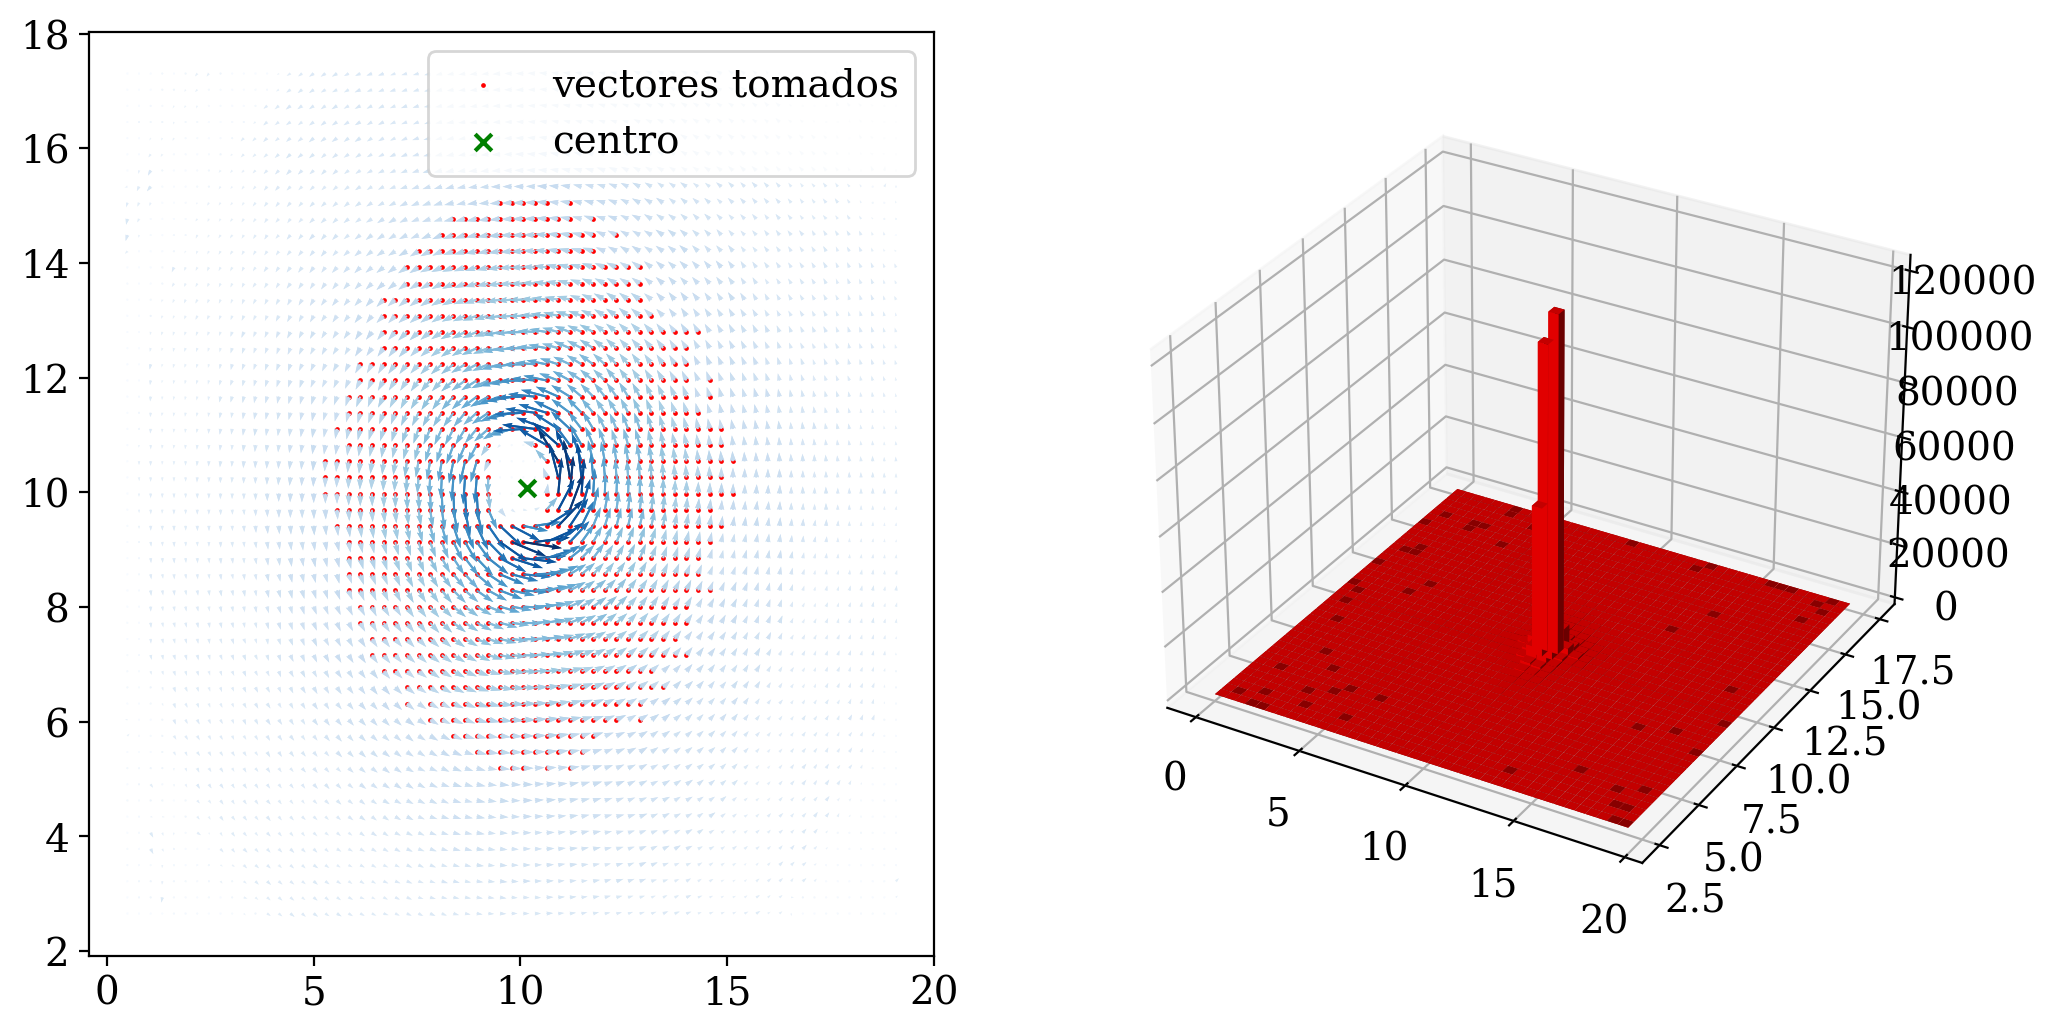

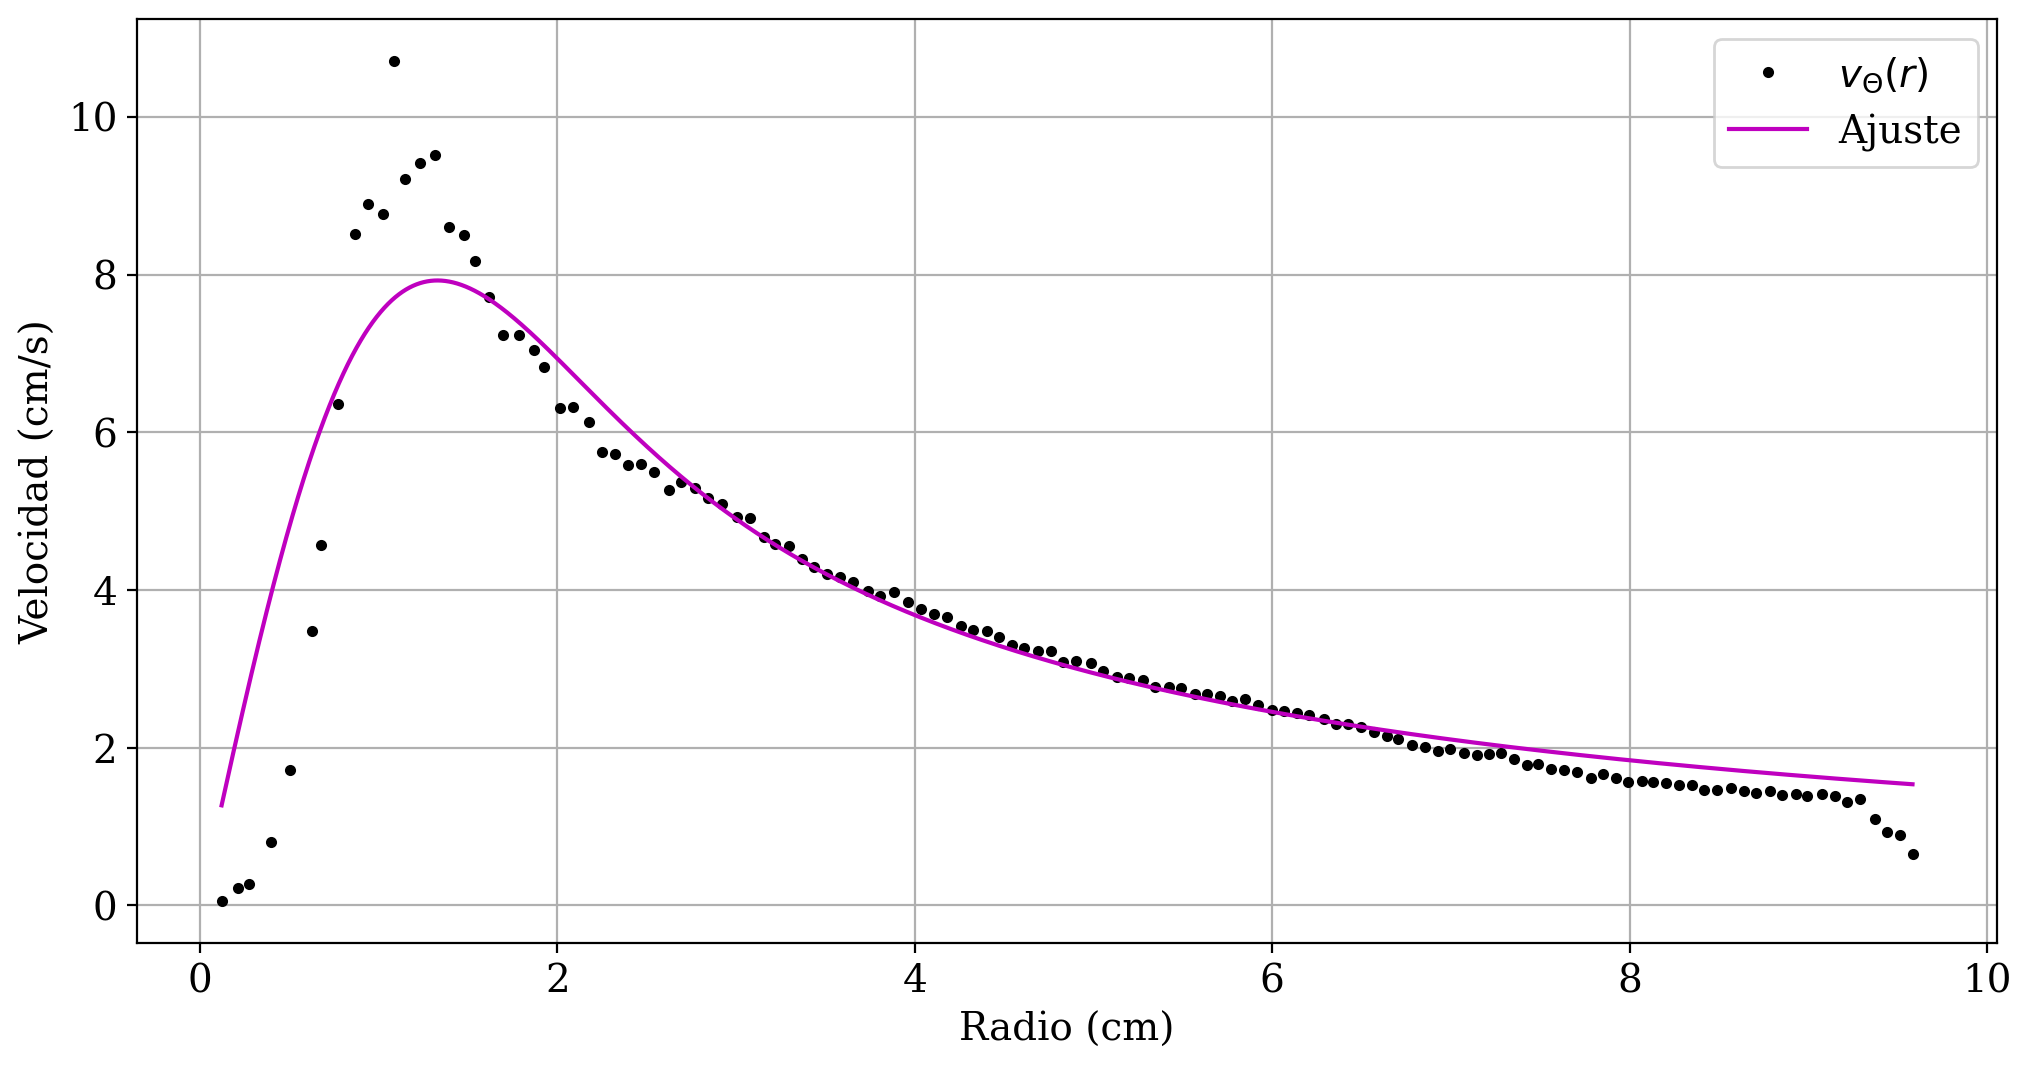

La velocidad angular Omega es 10.47 con error 0.602
El radio del vortice c es 1.186 con error 0.0317


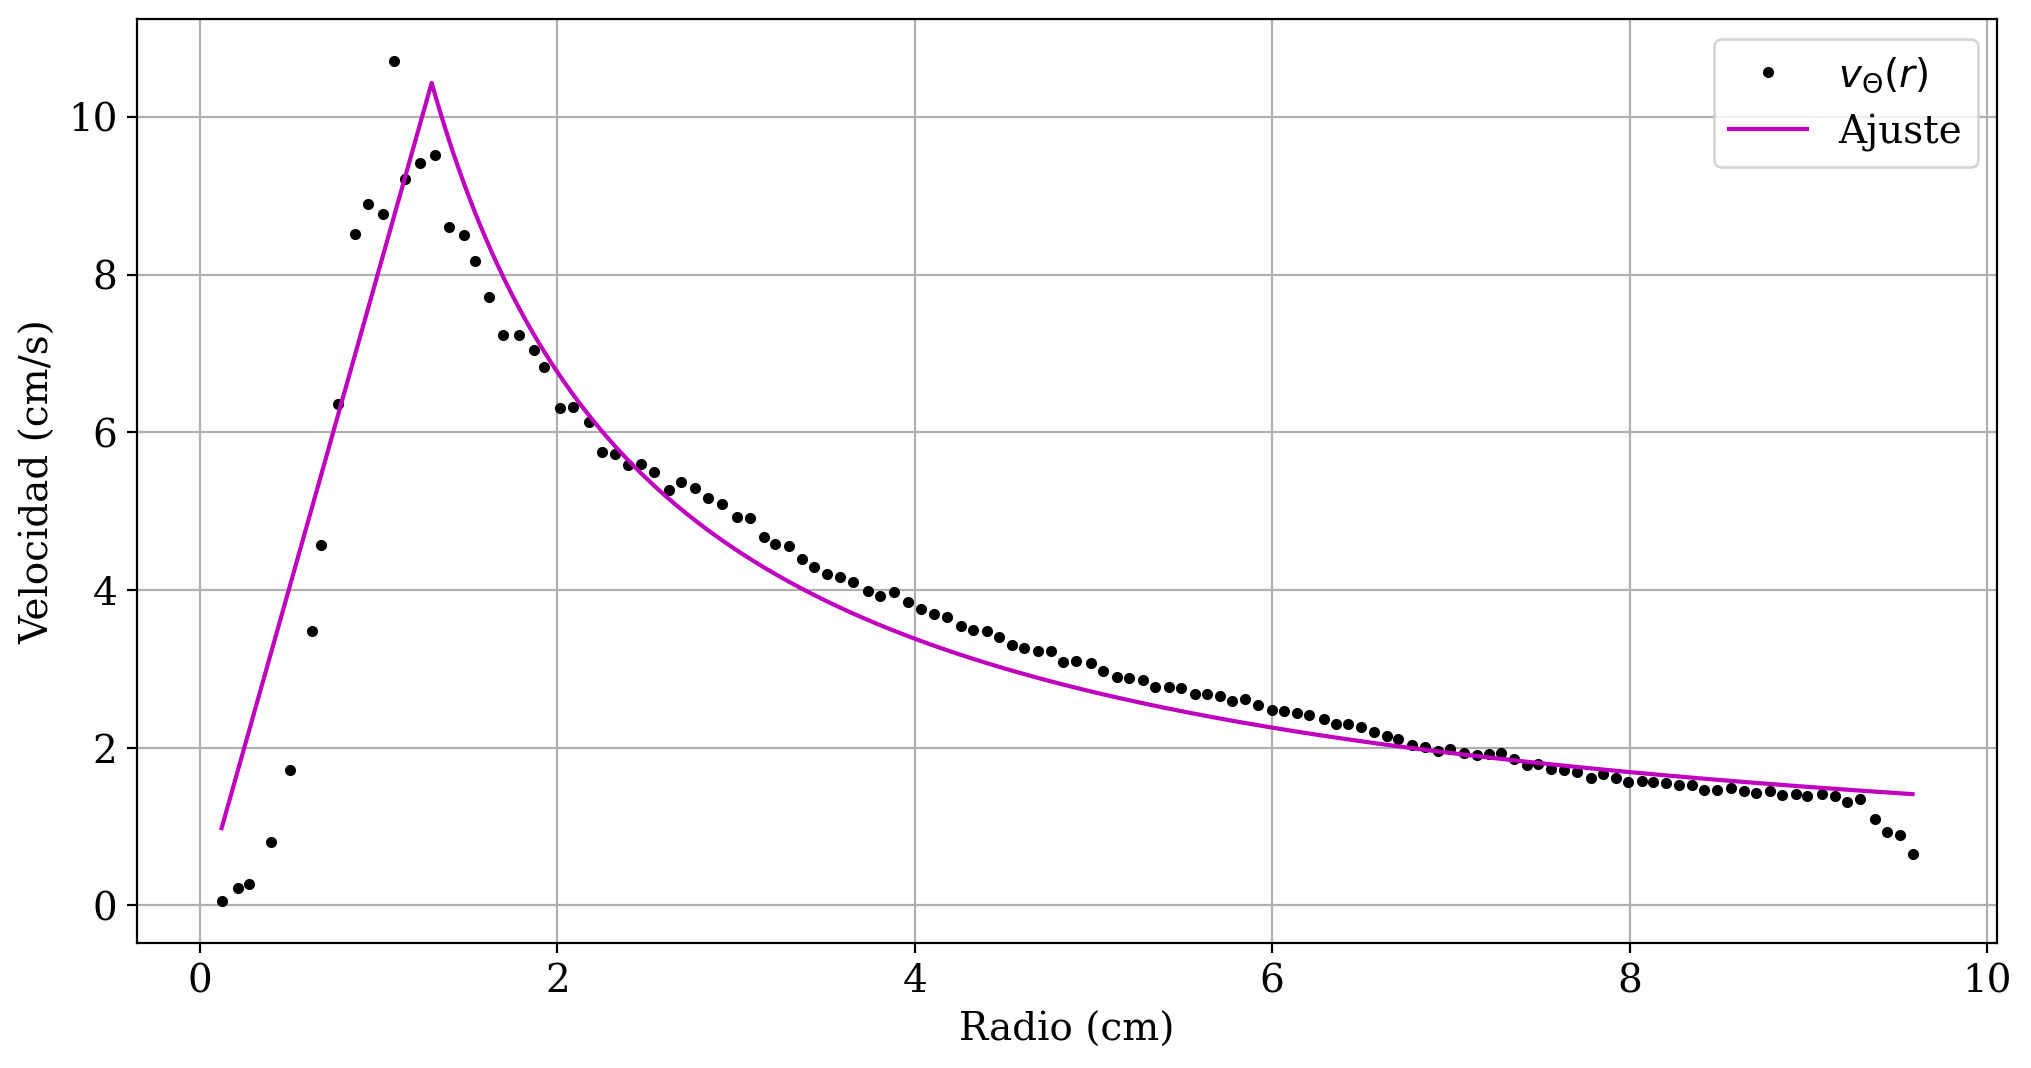

La velocidad angular Omega es 8.041 con error 0.195
El radio del vortice c es 1.297 con error 0.0182


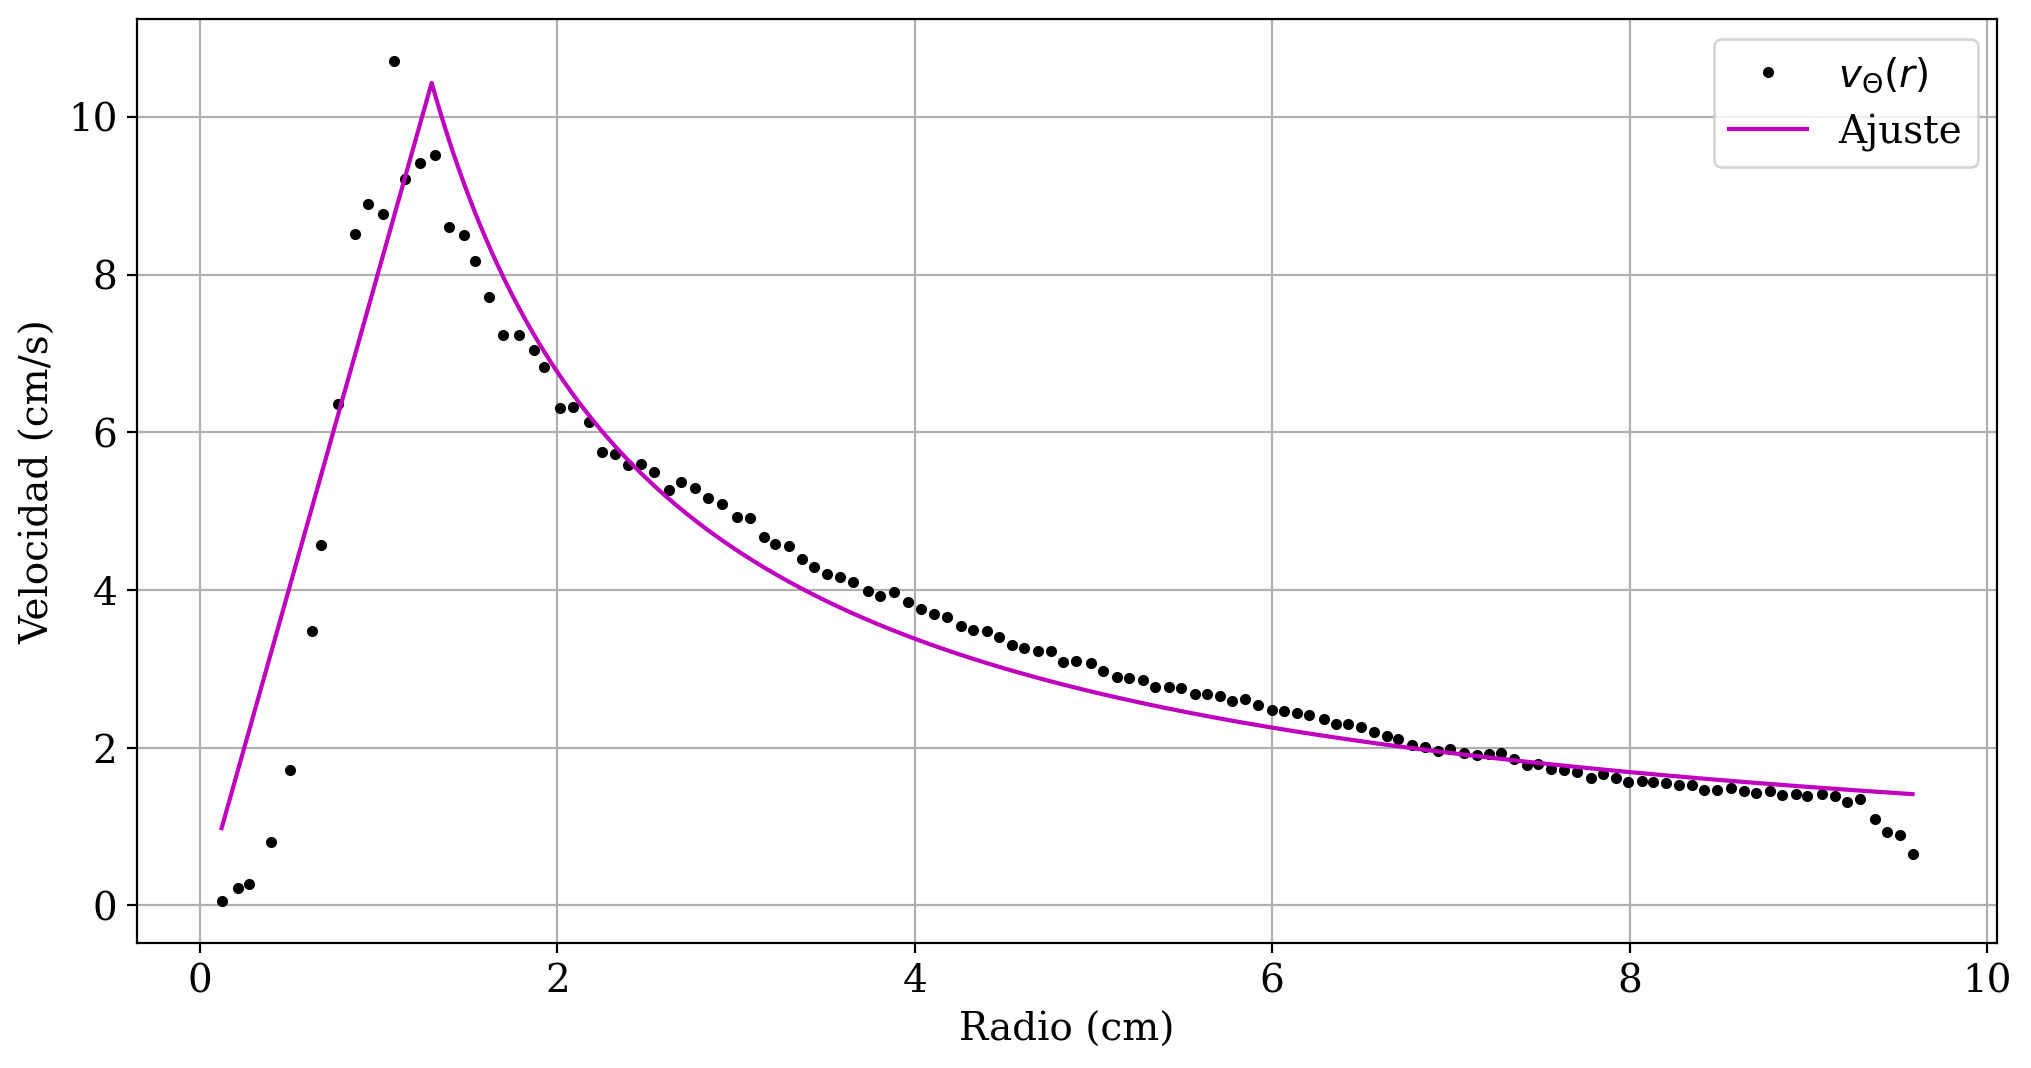

La velocidad angular Omega es 8.041 con error 0.195
El radio del vortice c es 1.297 con error 0.0182


In [46]:
radio_recipiente = 9.65

path = "nuevas mediciones/destilada lento dos filtros/destilada lento.npz"
find_center(path, r_max=radio_recipiente, y_lims=[2.5,17.5], v_quantile=.75)

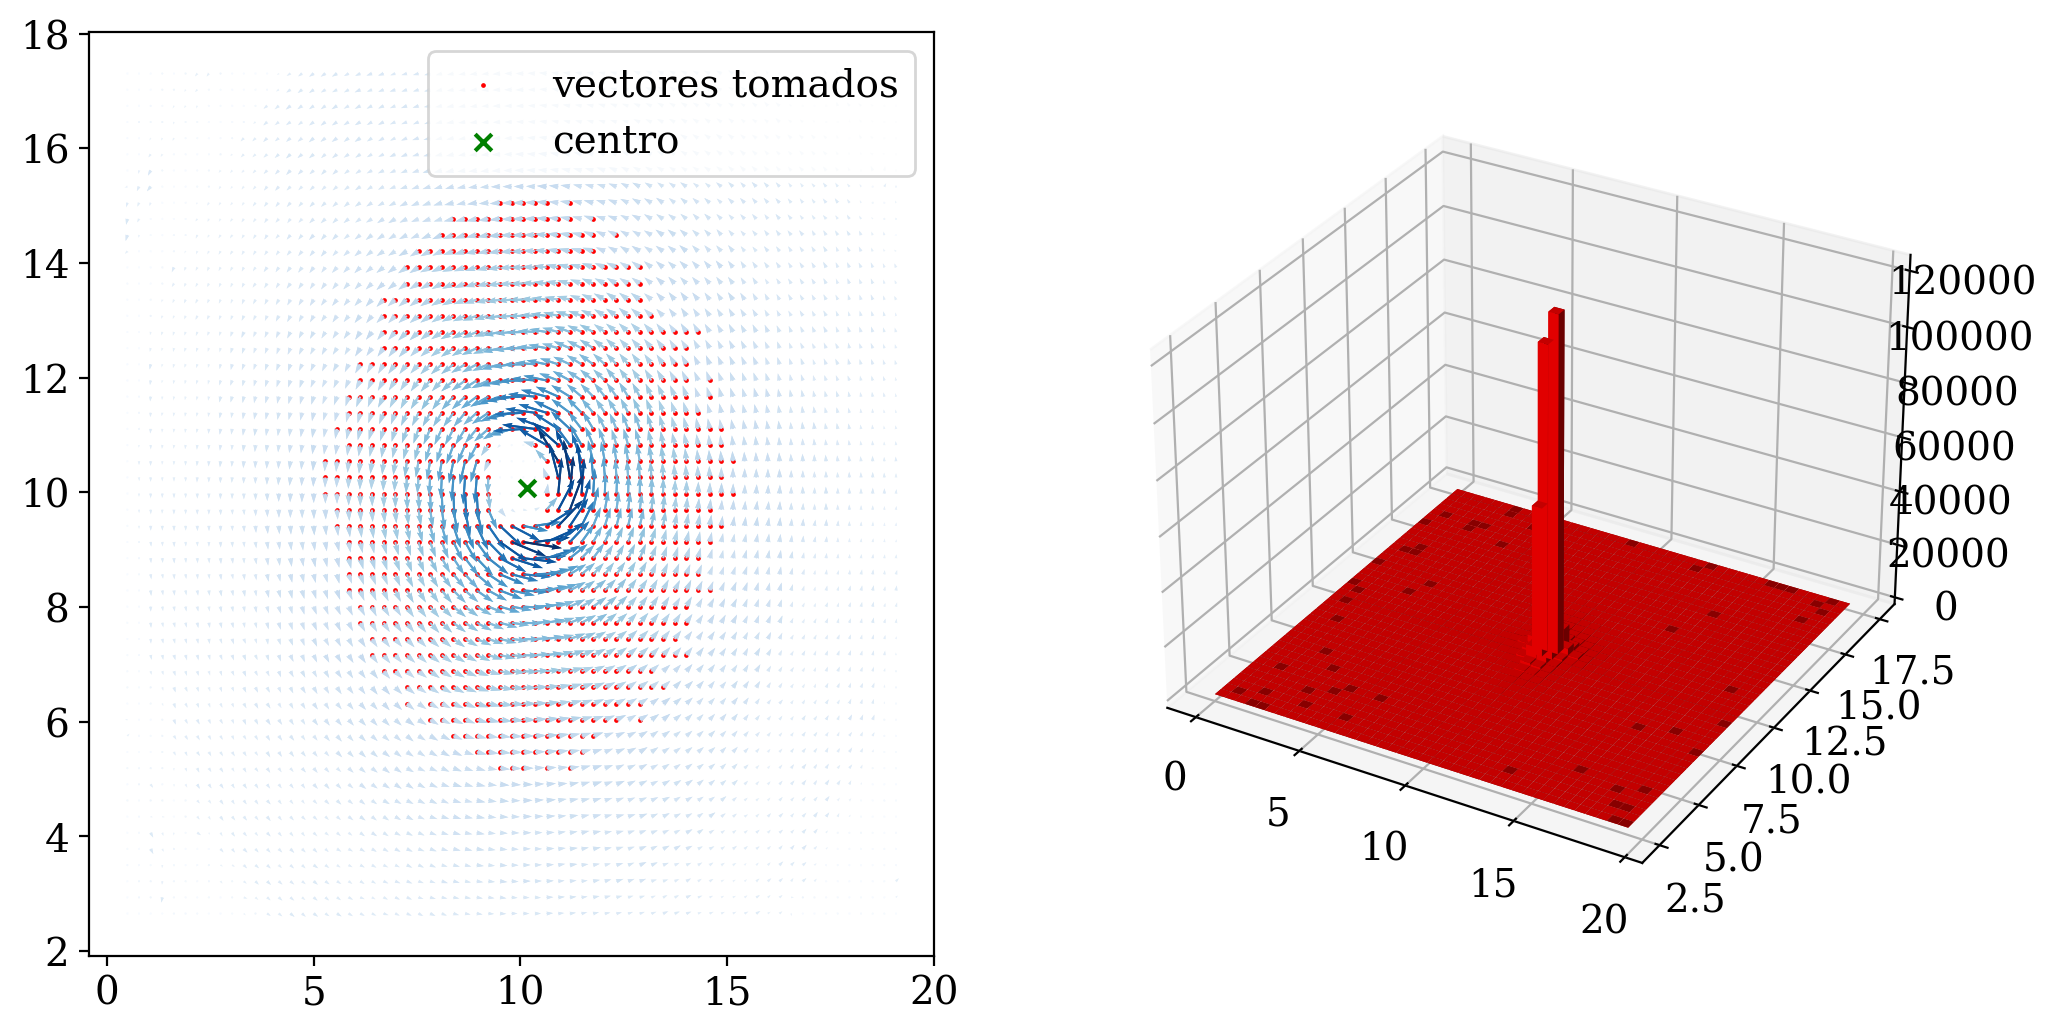

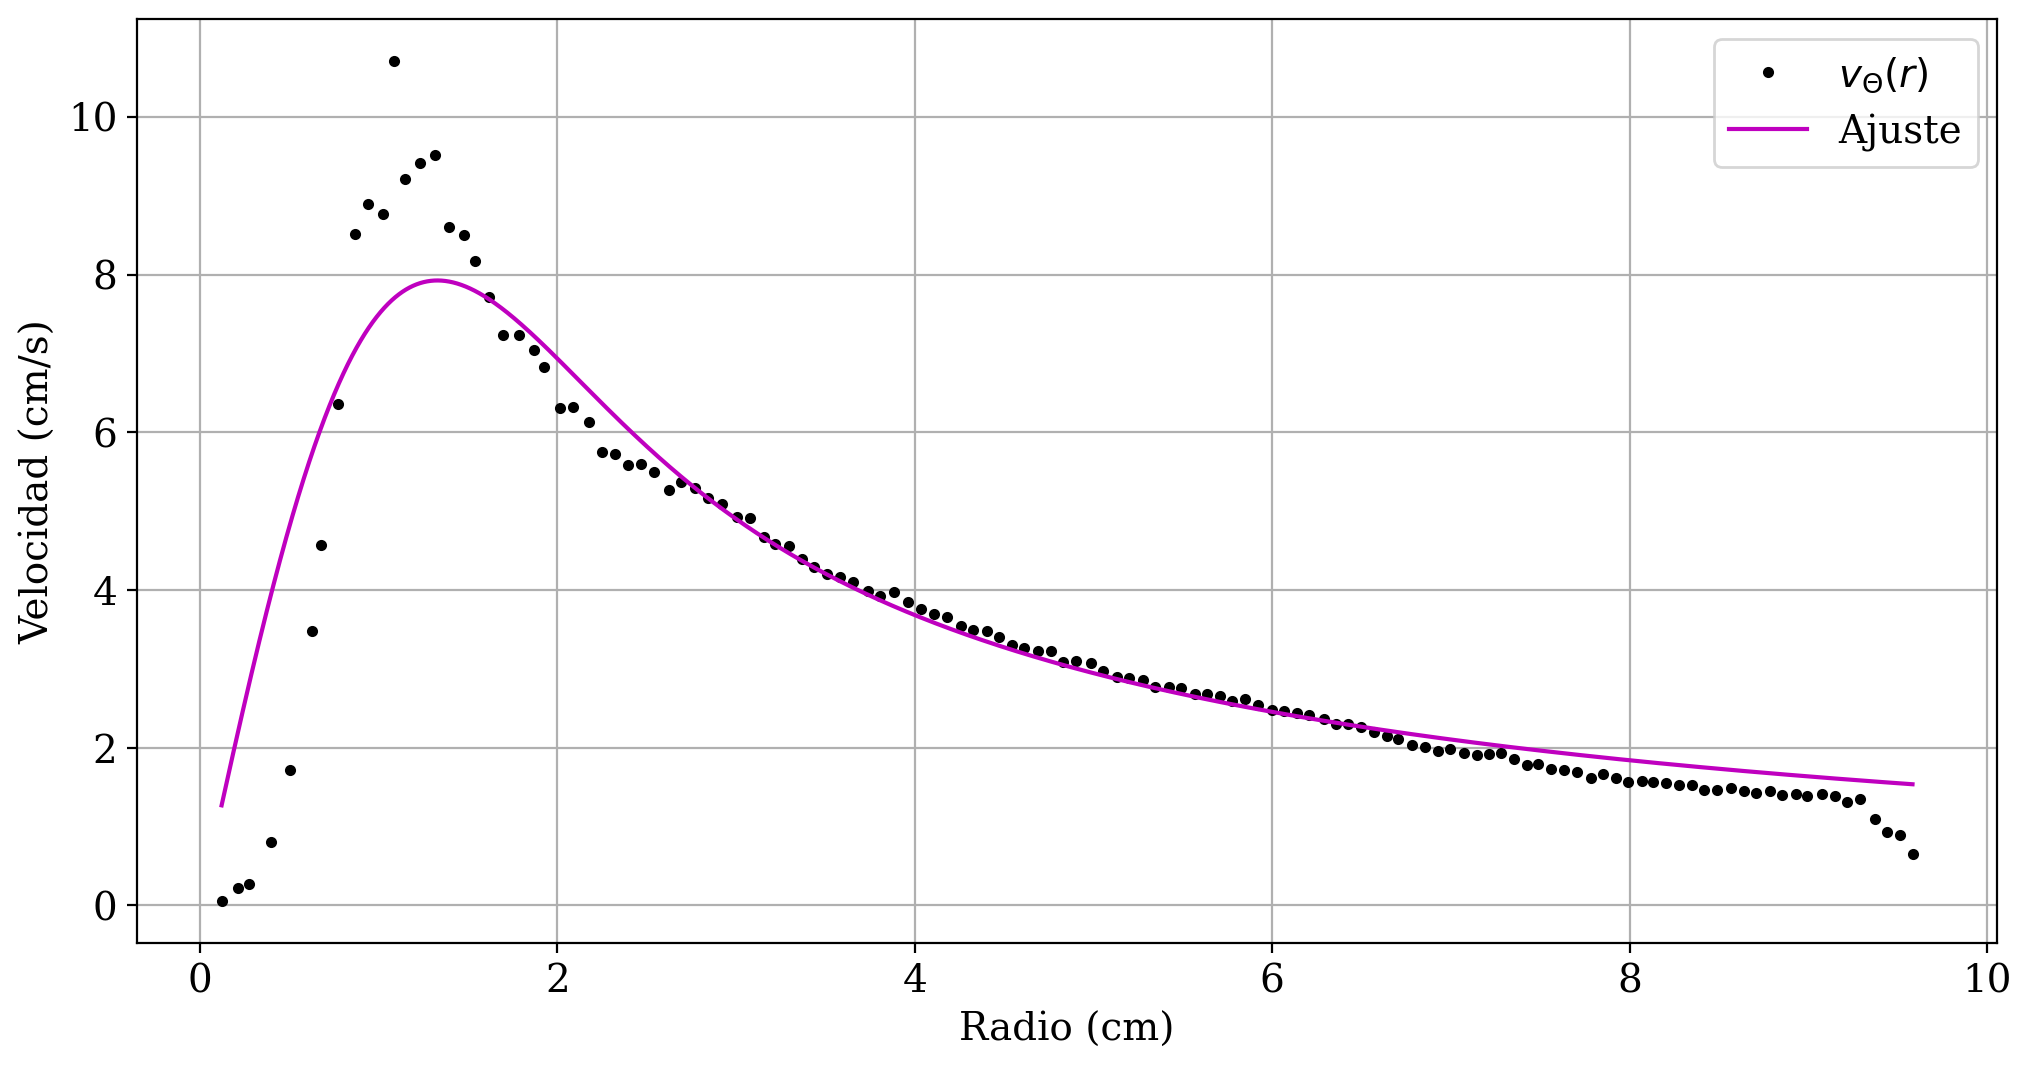

La velocidad angular Omega es 10.47 con error 0.602
El radio del vortice c es 1.186 con error 0.0317


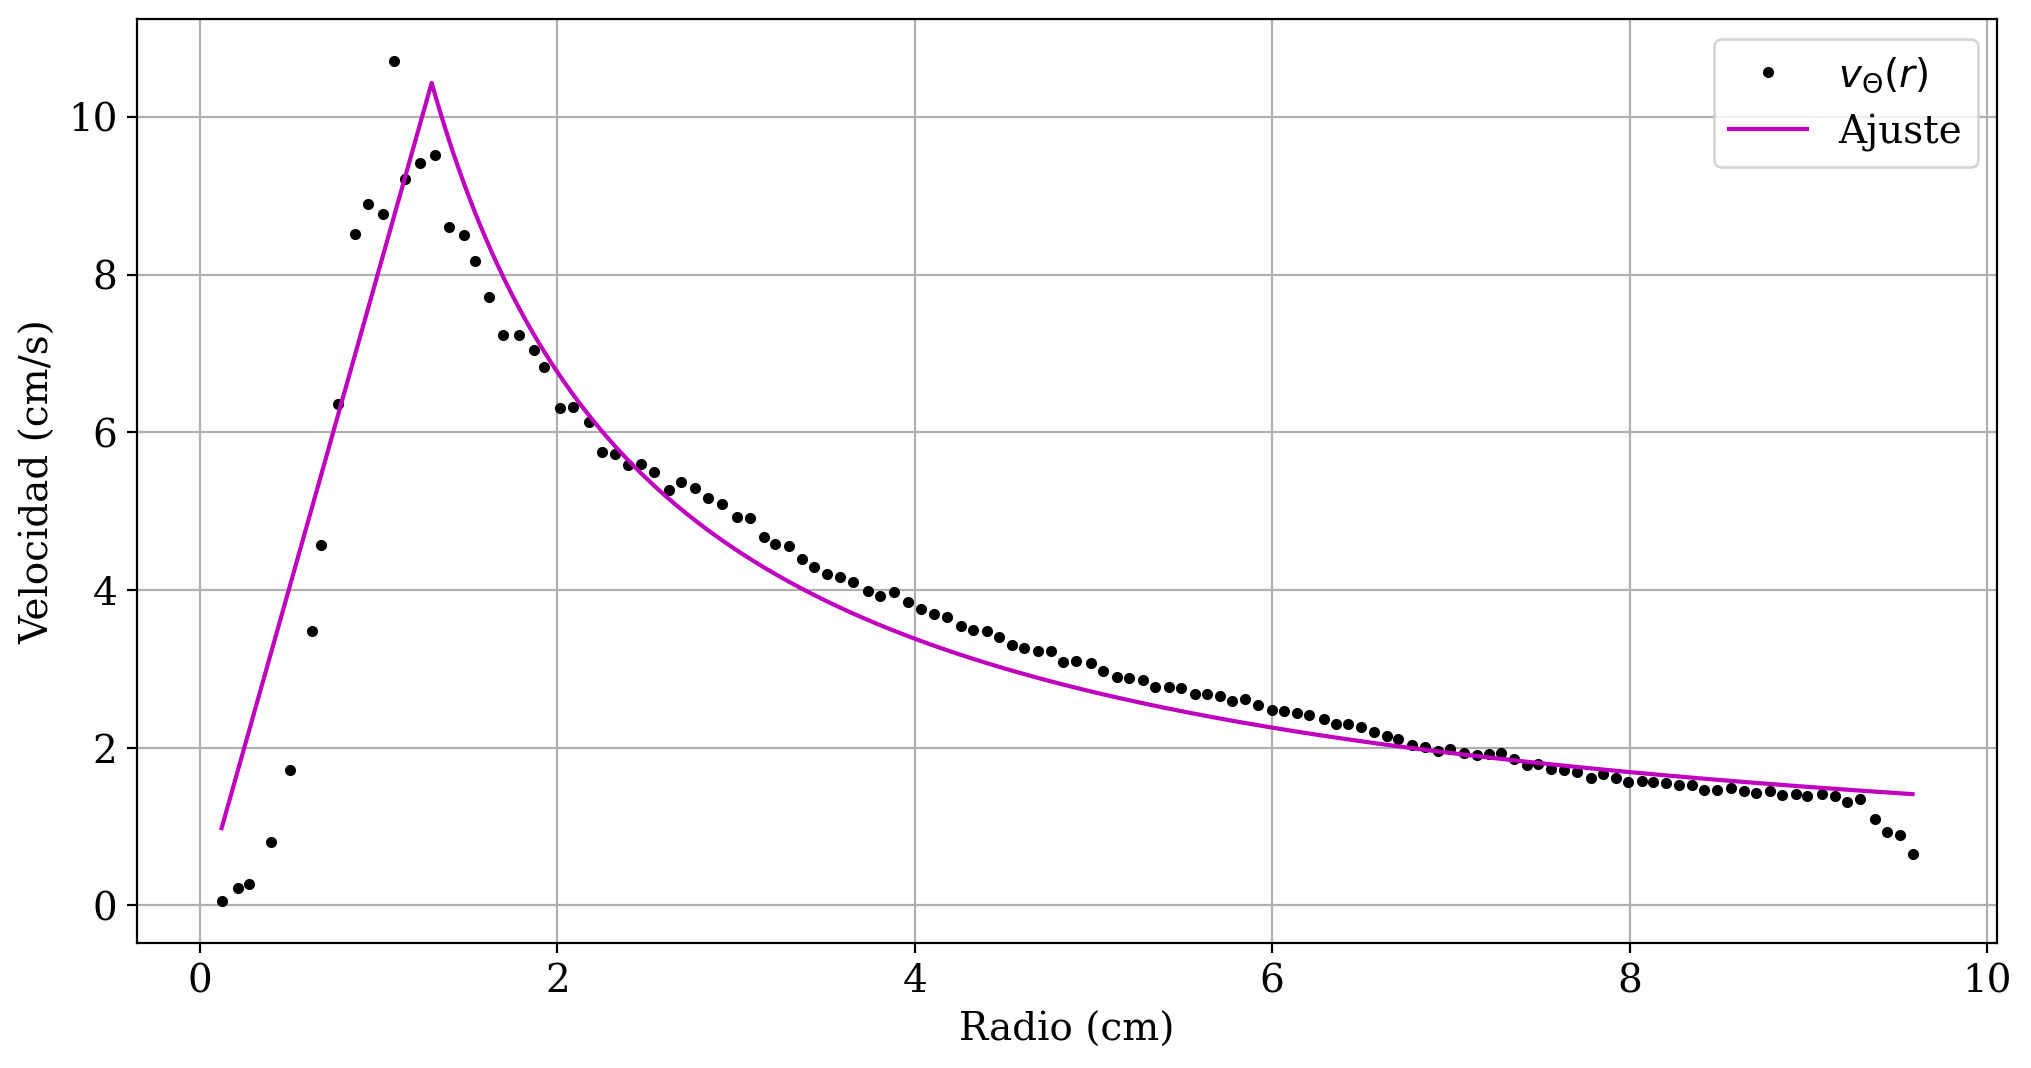

La velocidad angular Omega es 8.041 con error 0.195
El radio del vortice c es 1.297 con error 0.0182


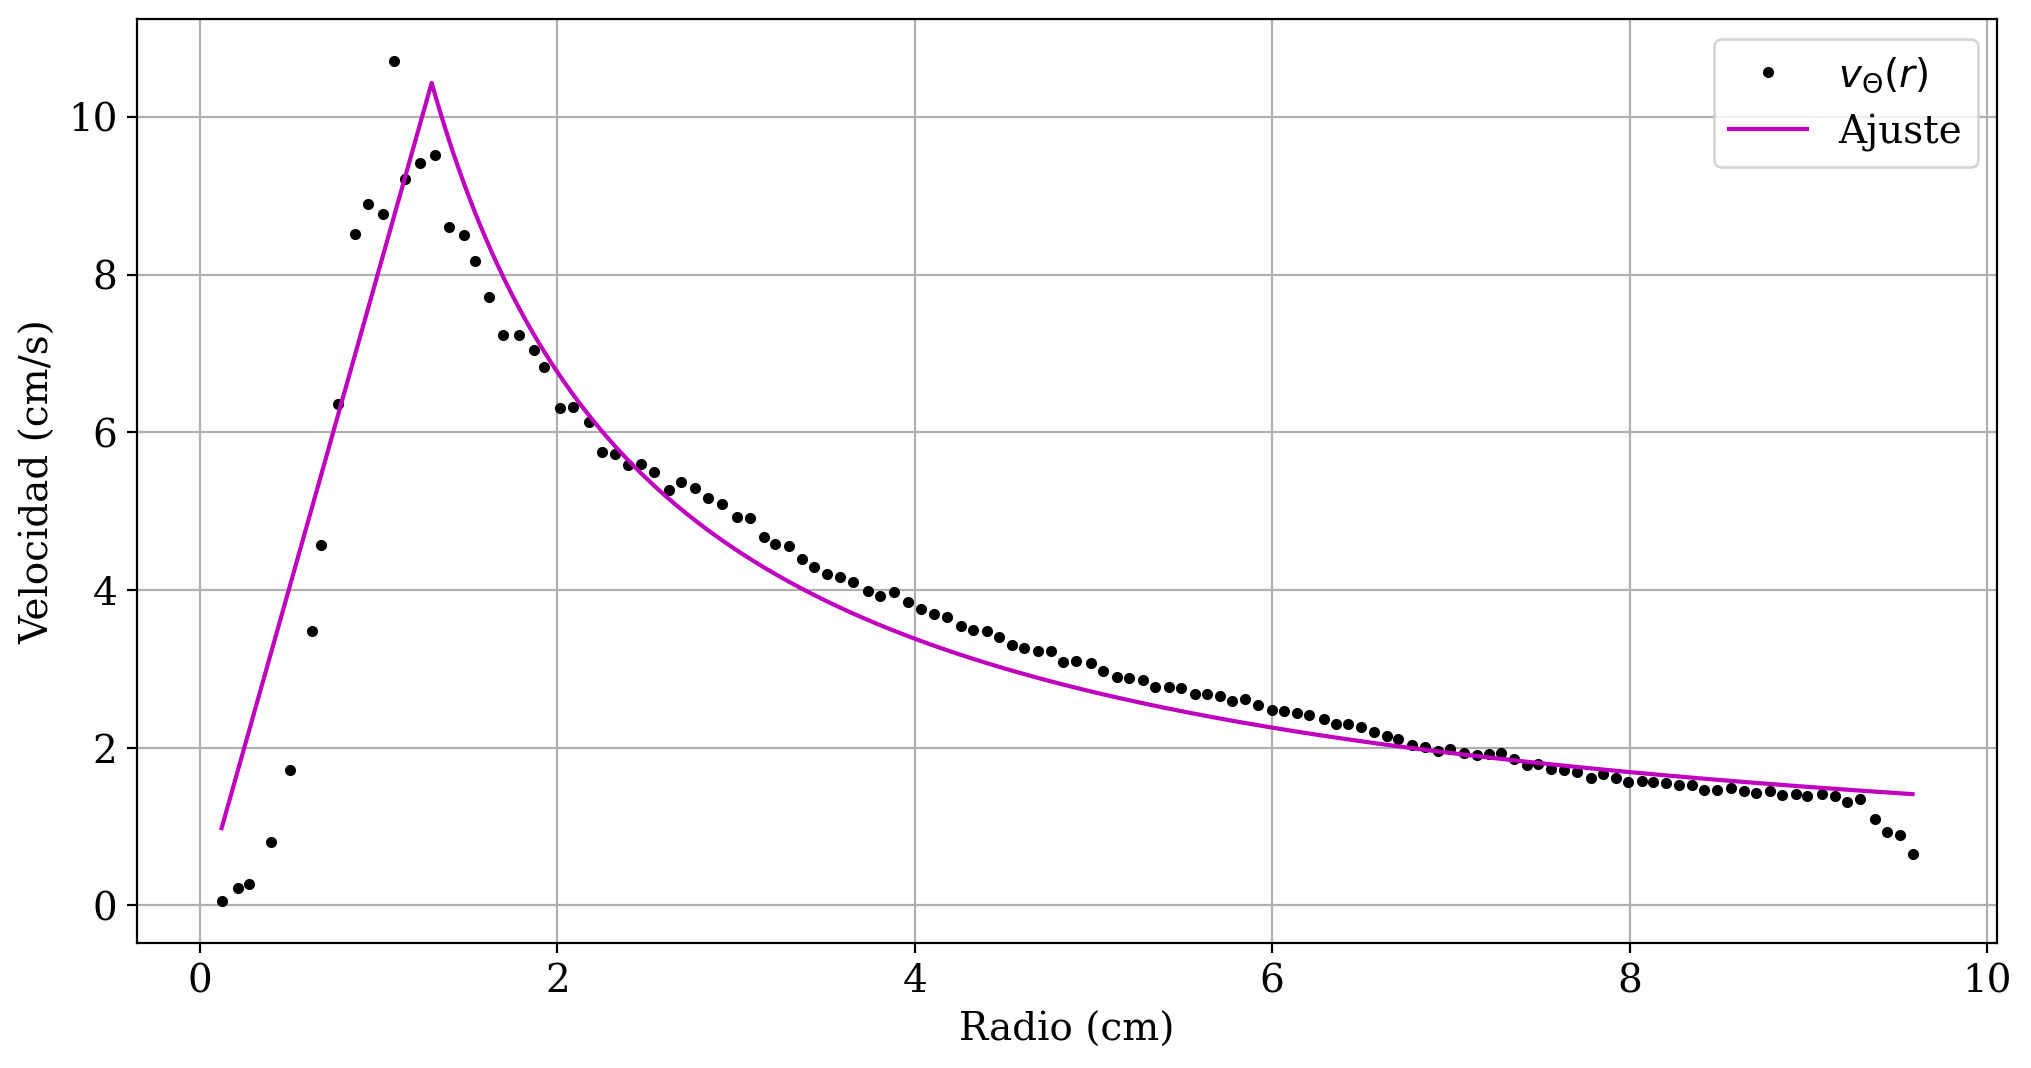

La velocidad angular Omega es 8.041 con error 0.195
El radio del vortice c es 1.297 con error 0.0182


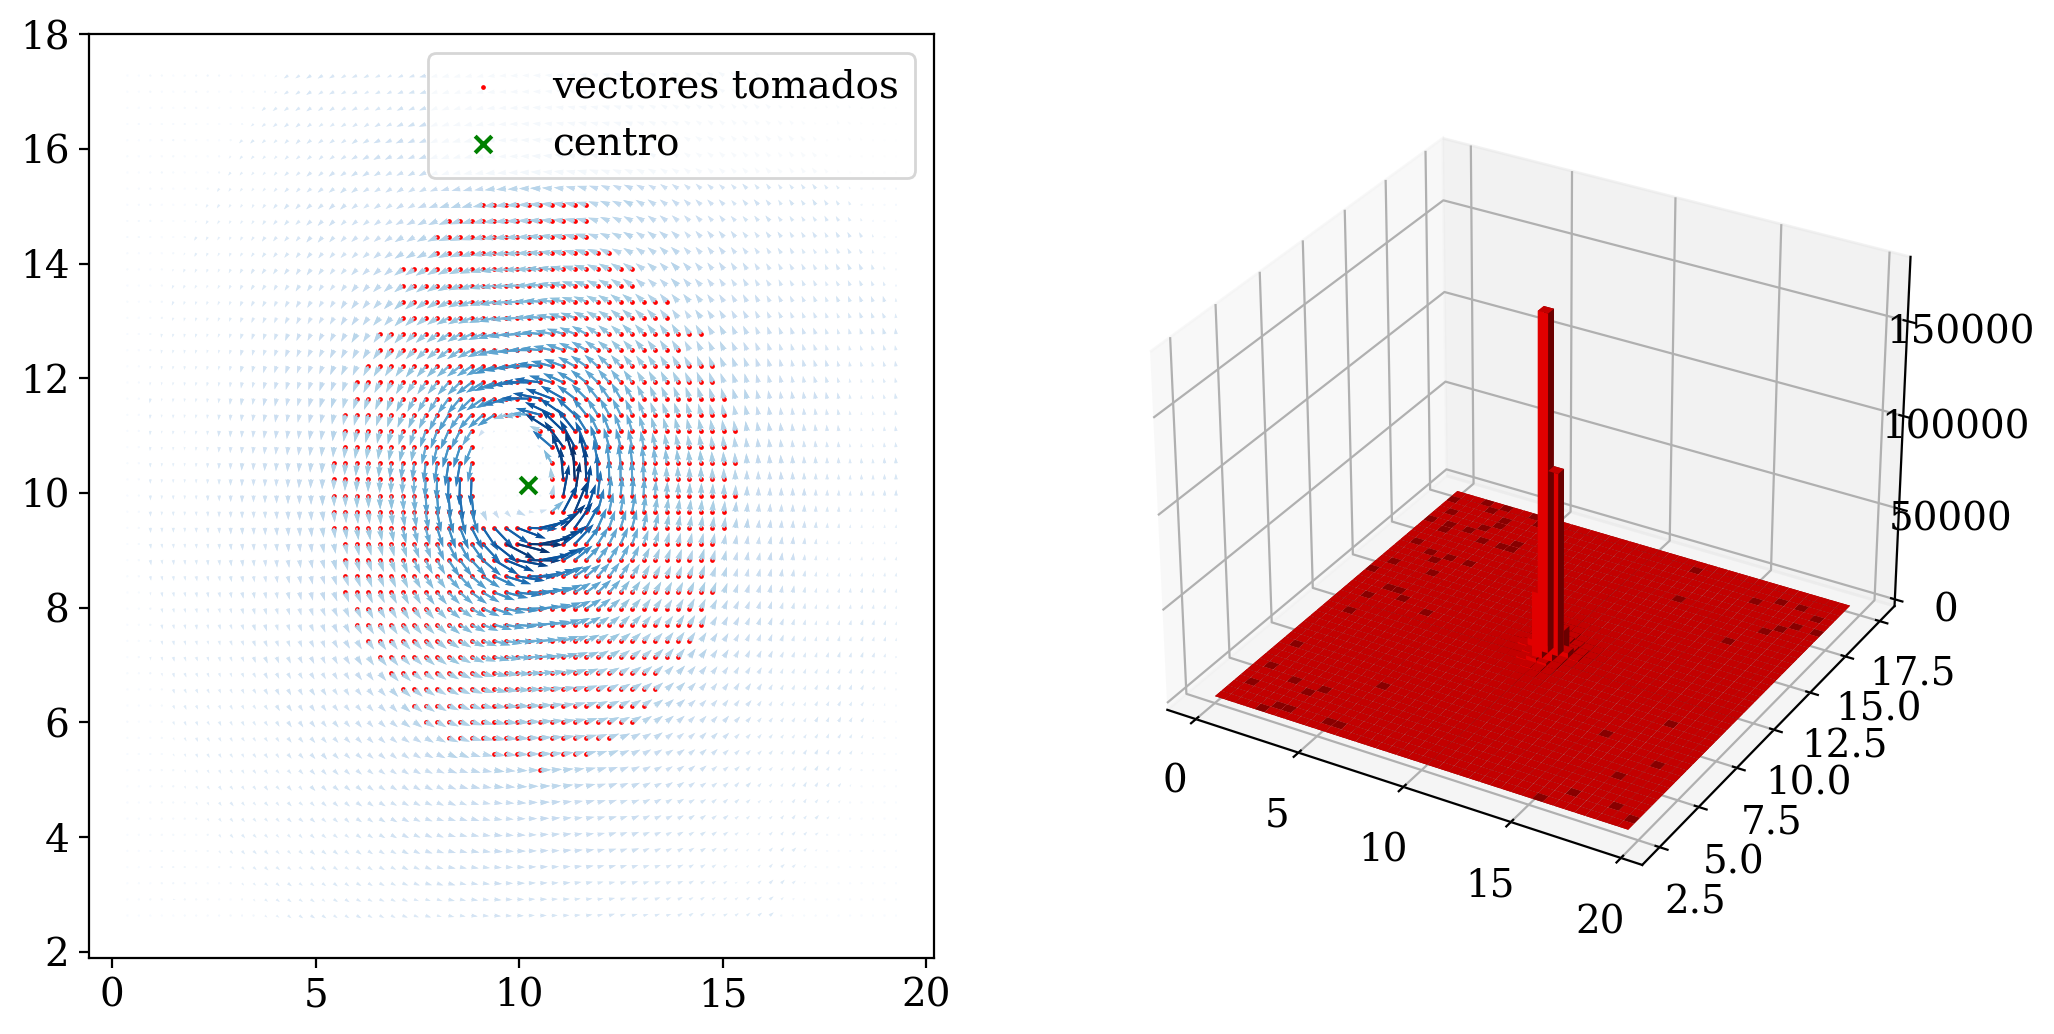

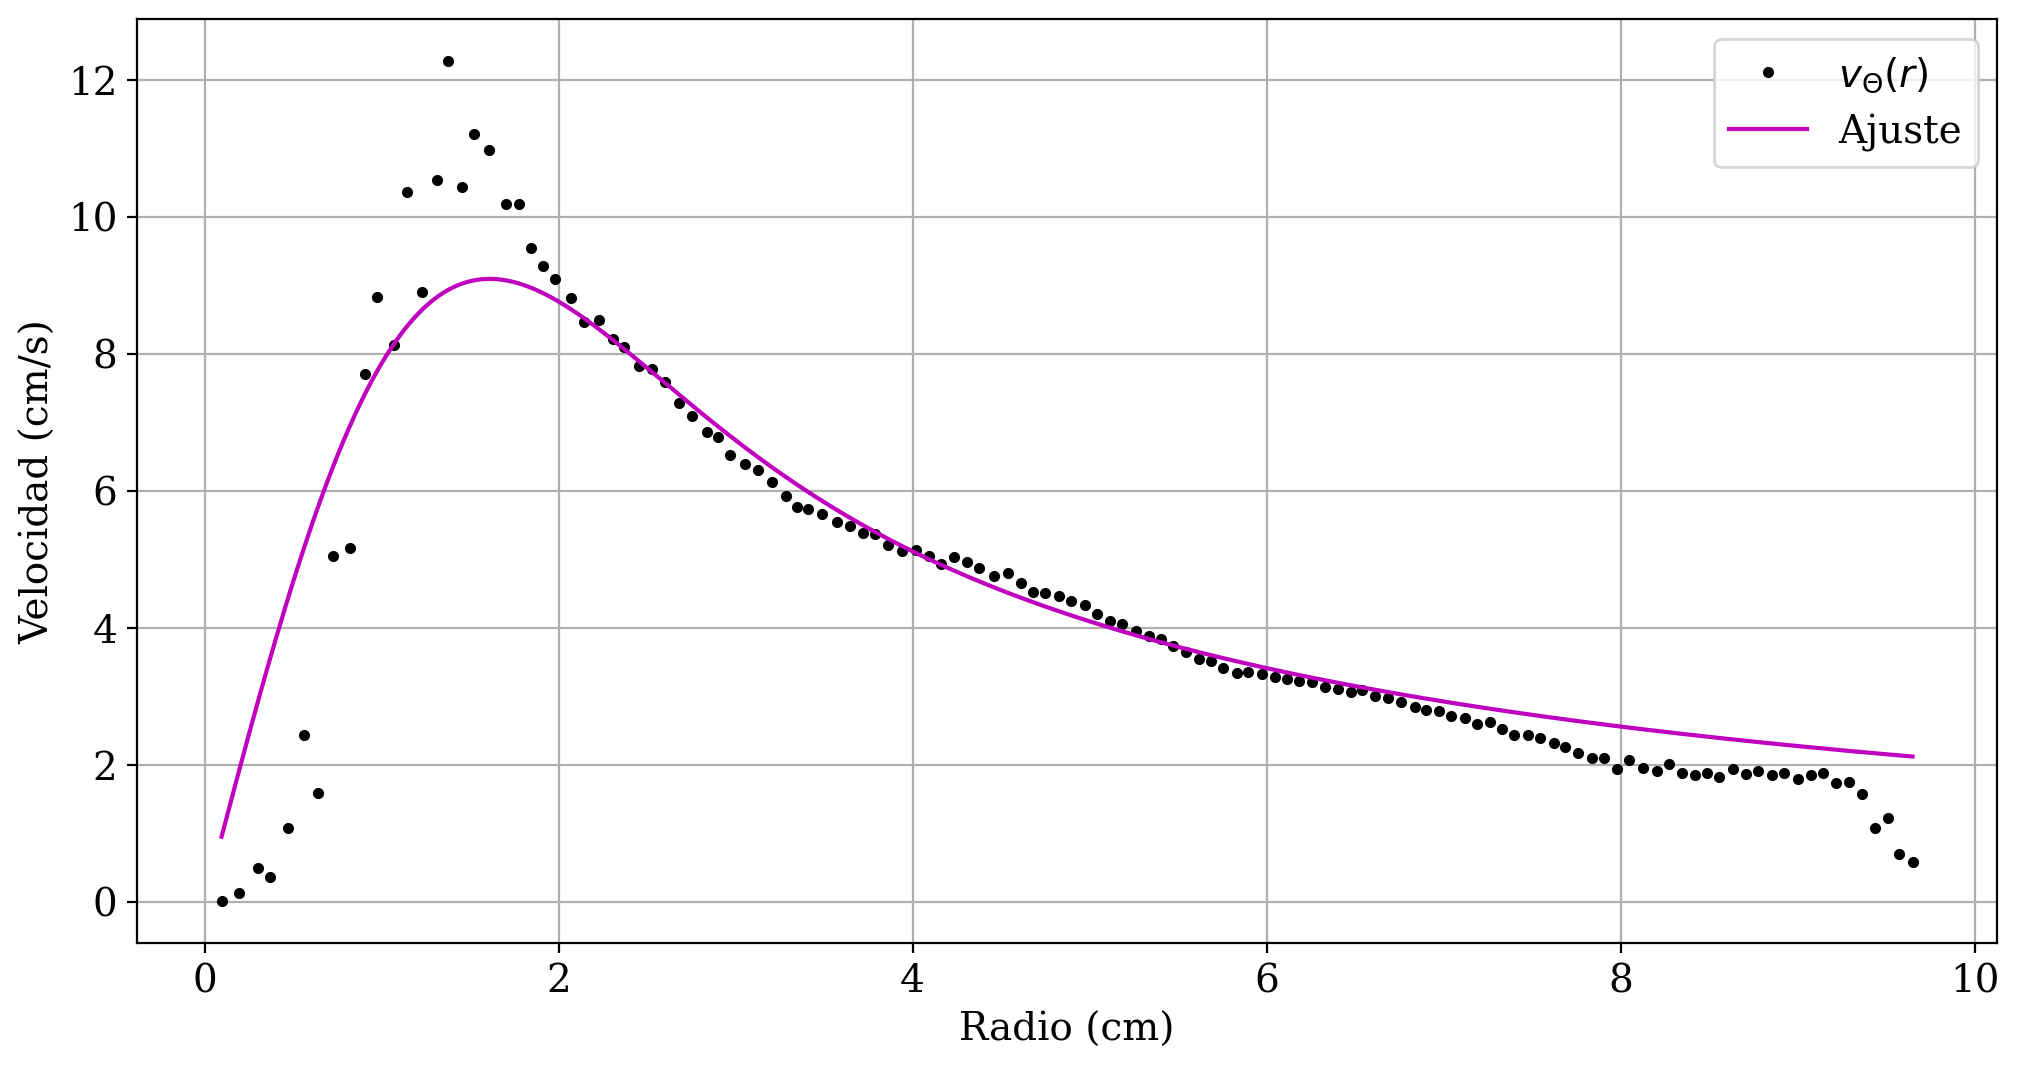

La velocidad angular Omega es 9.915 con error 0.572
El radio del vortice c es 1.437 con error 0.0384


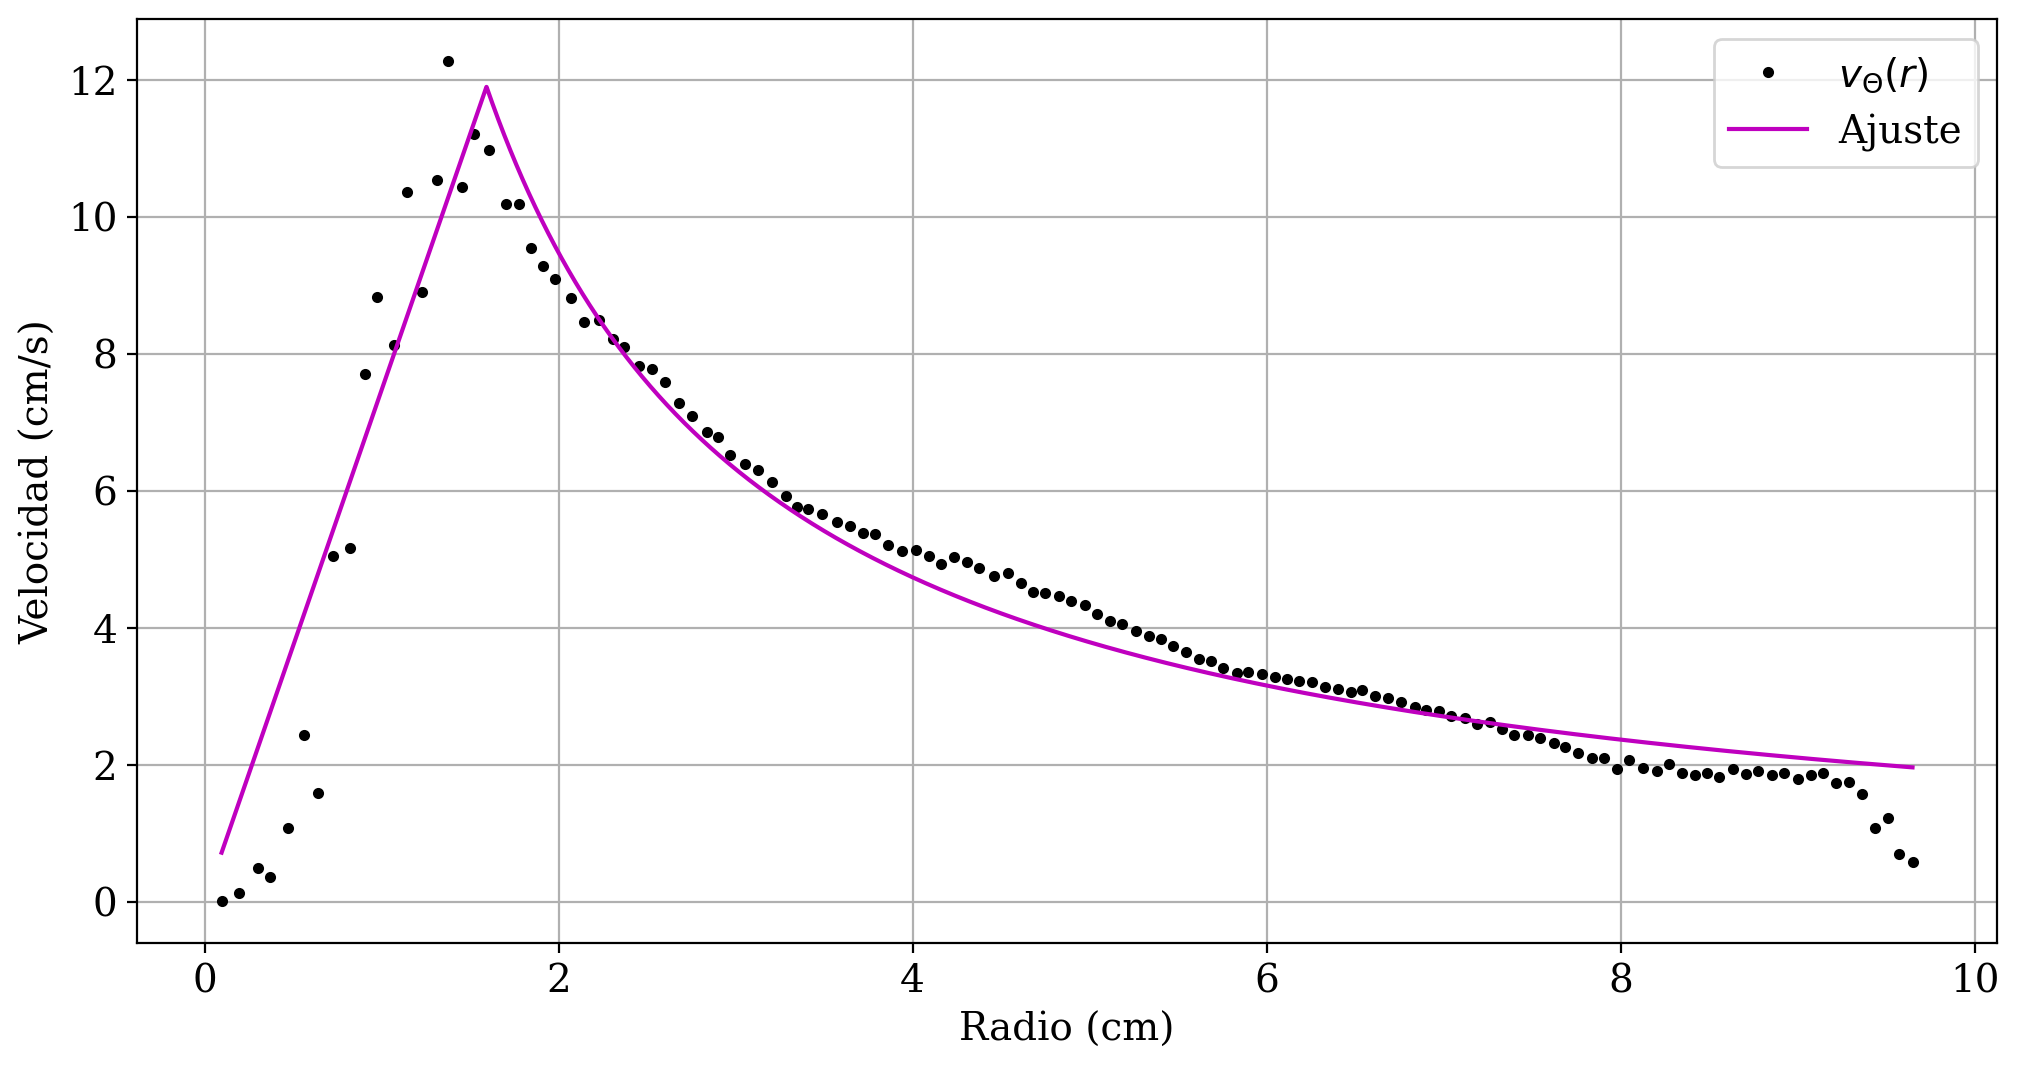

La velocidad angular Omega es 7.47 con error 0.171
El radio del vortice c es 1.593 con error 0.0212


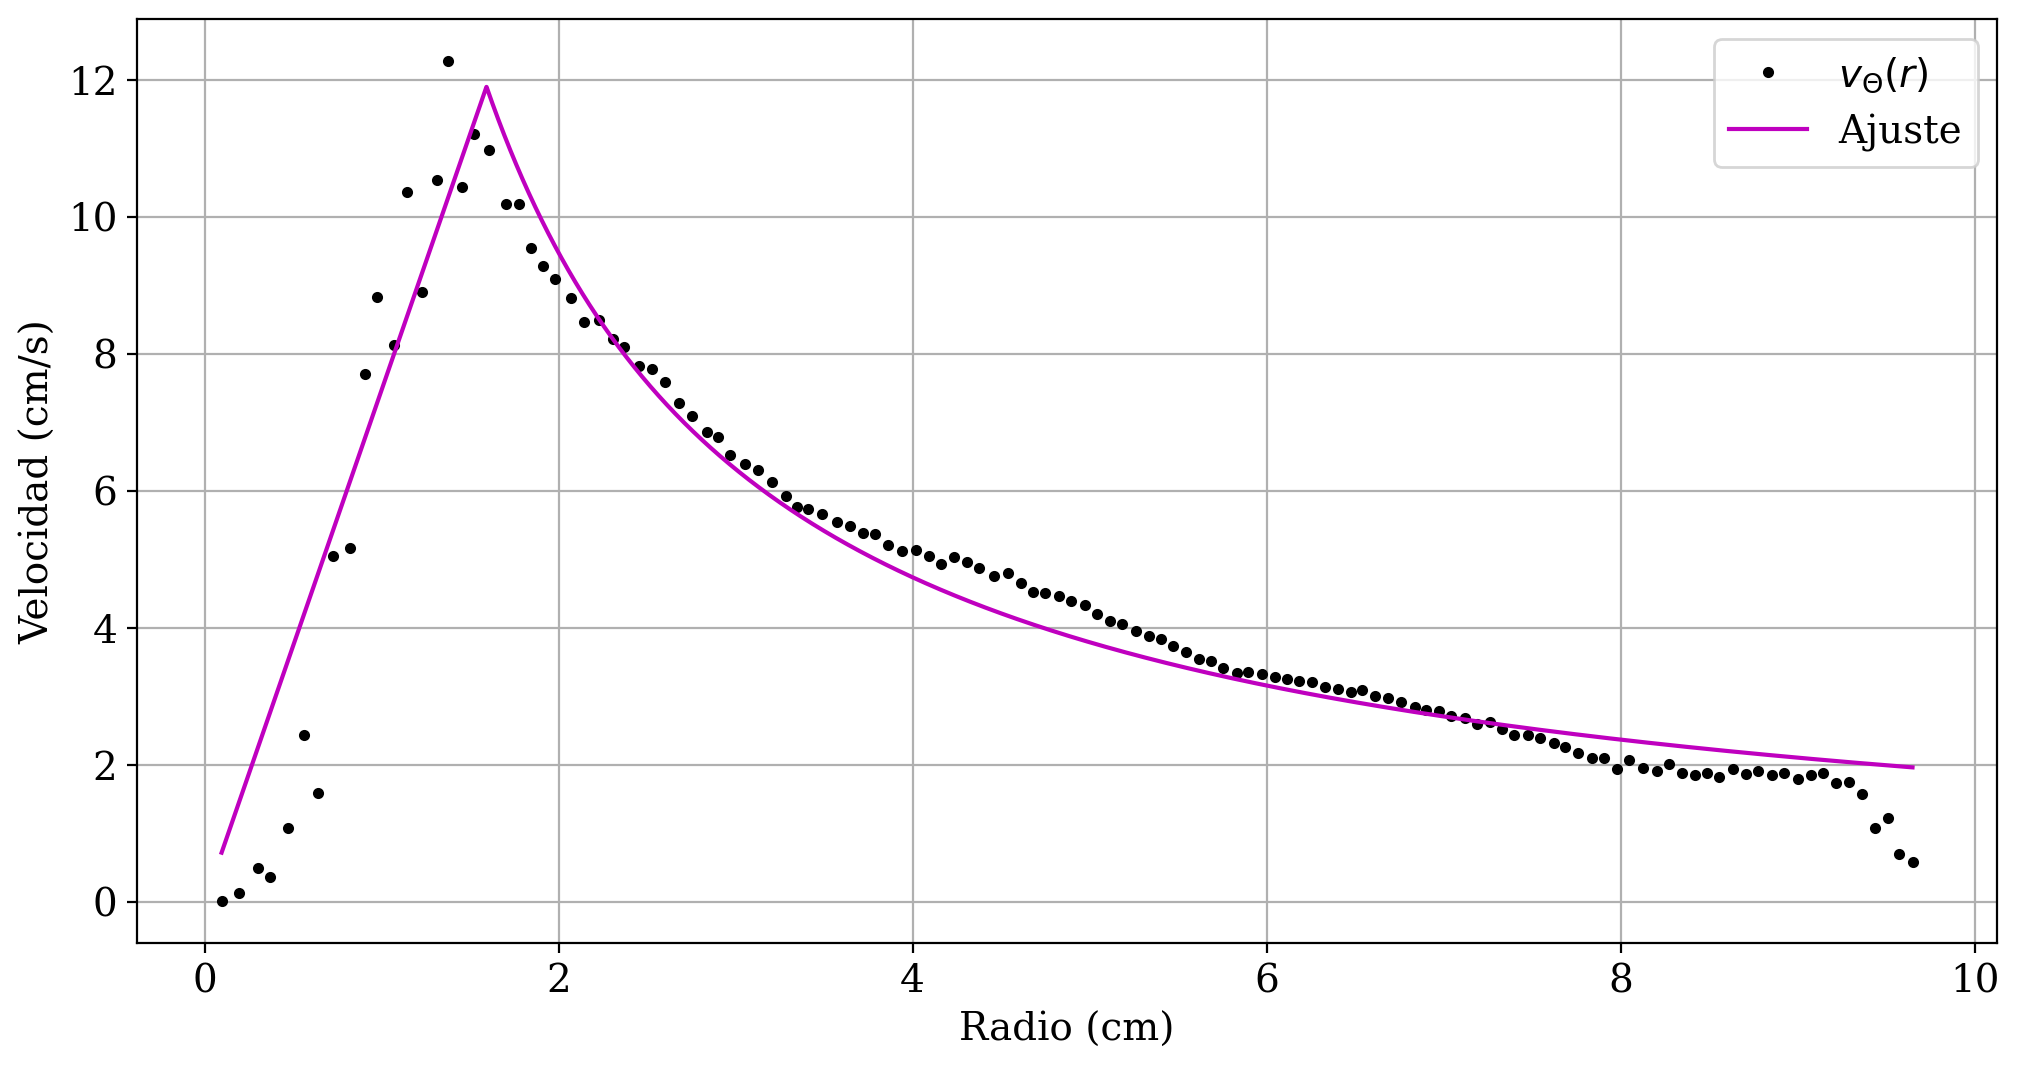

La velocidad angular Omega es 7.47 con error 0.171
El radio del vortice c es 1.593 con error 0.0212


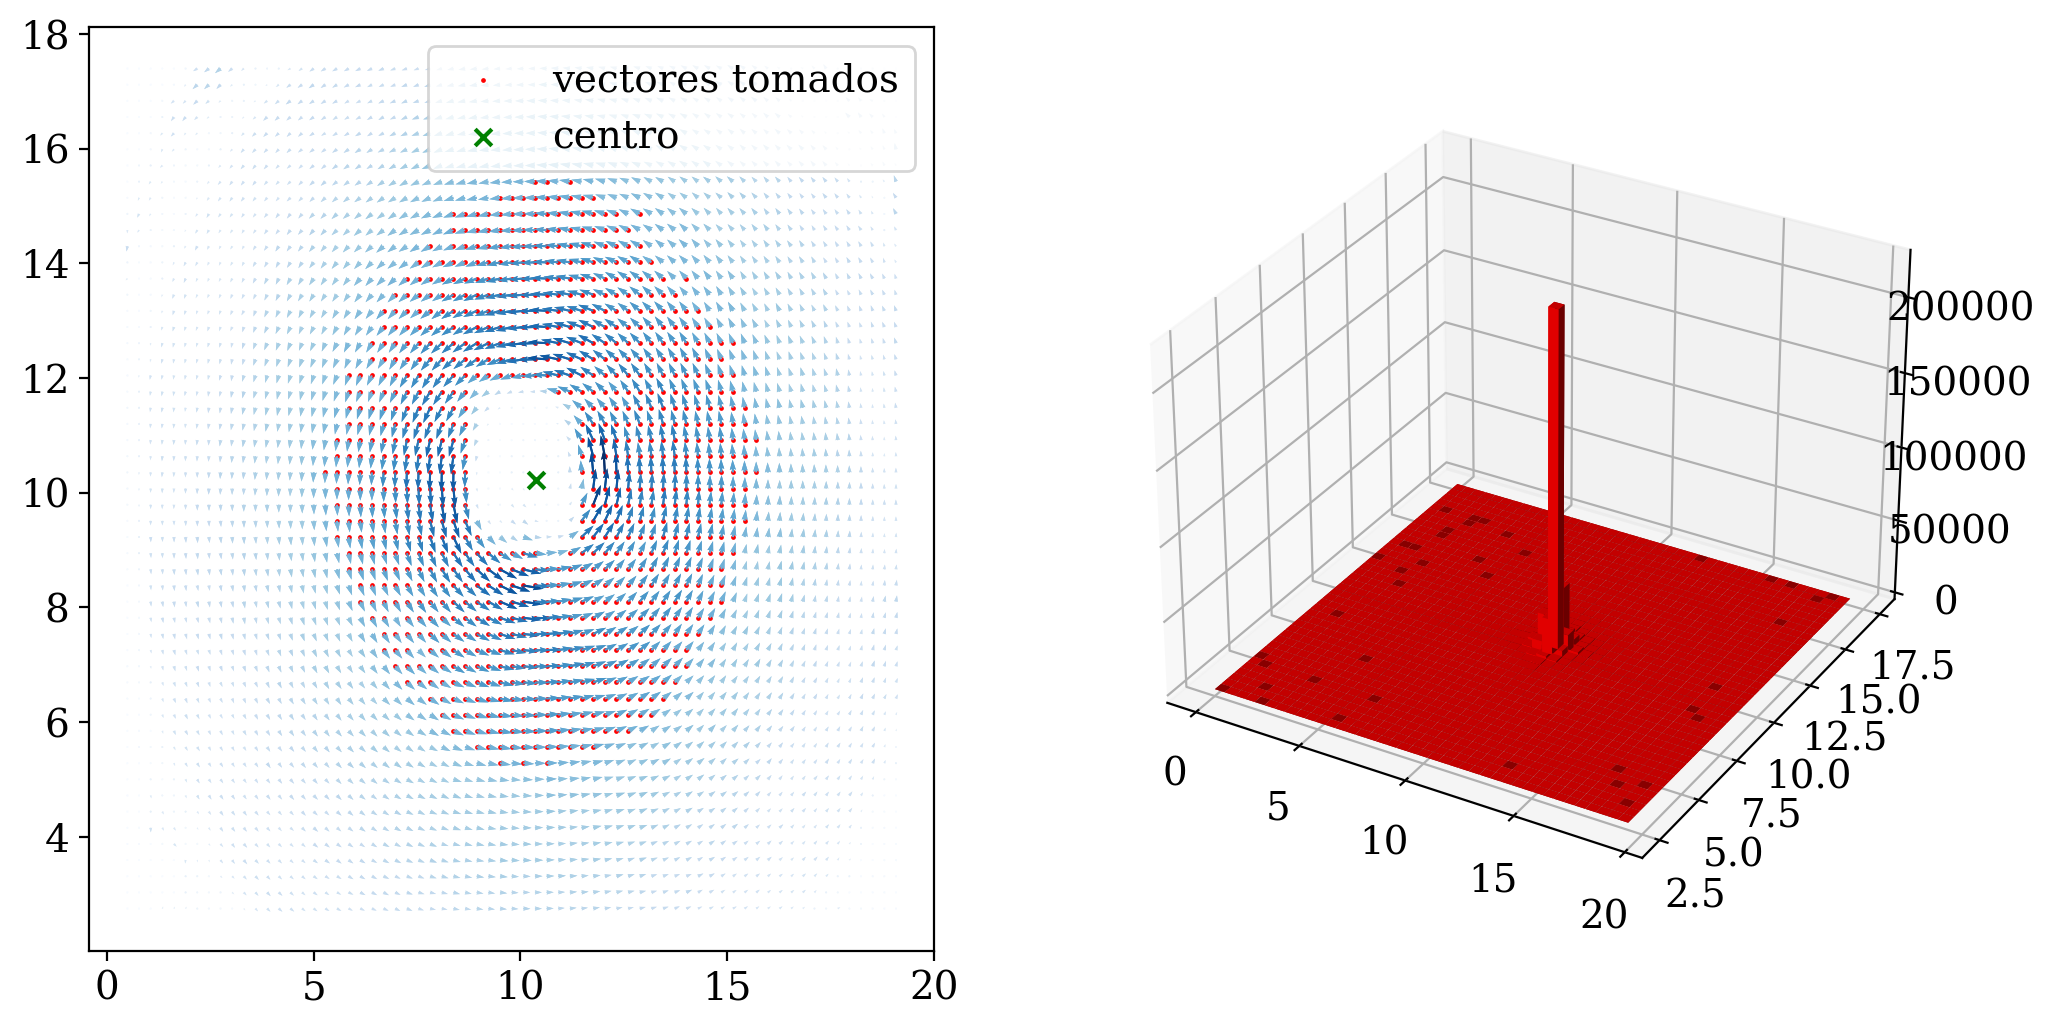

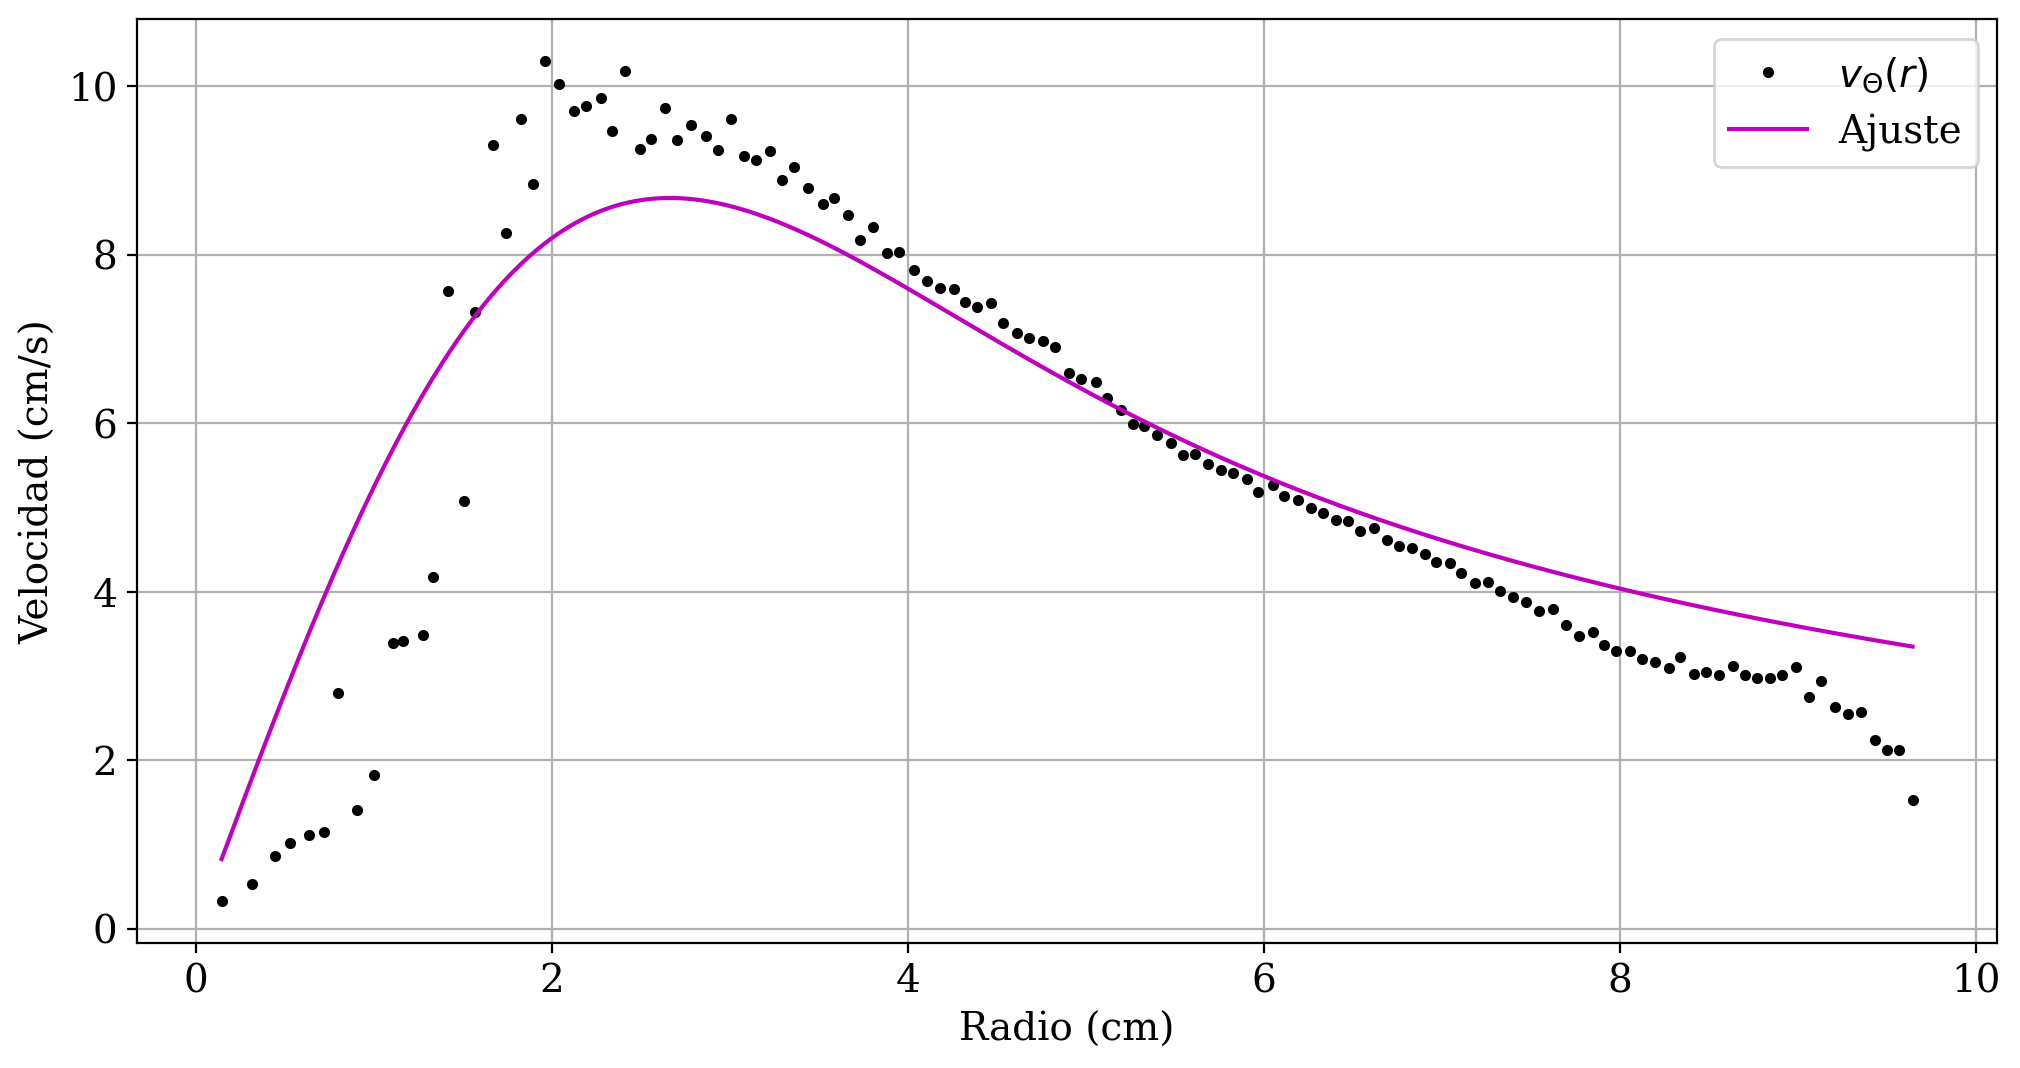

La velocidad angular Omega es 5.723 con error 0.32
El radio del vortice c es 2.375 con error 0.0611


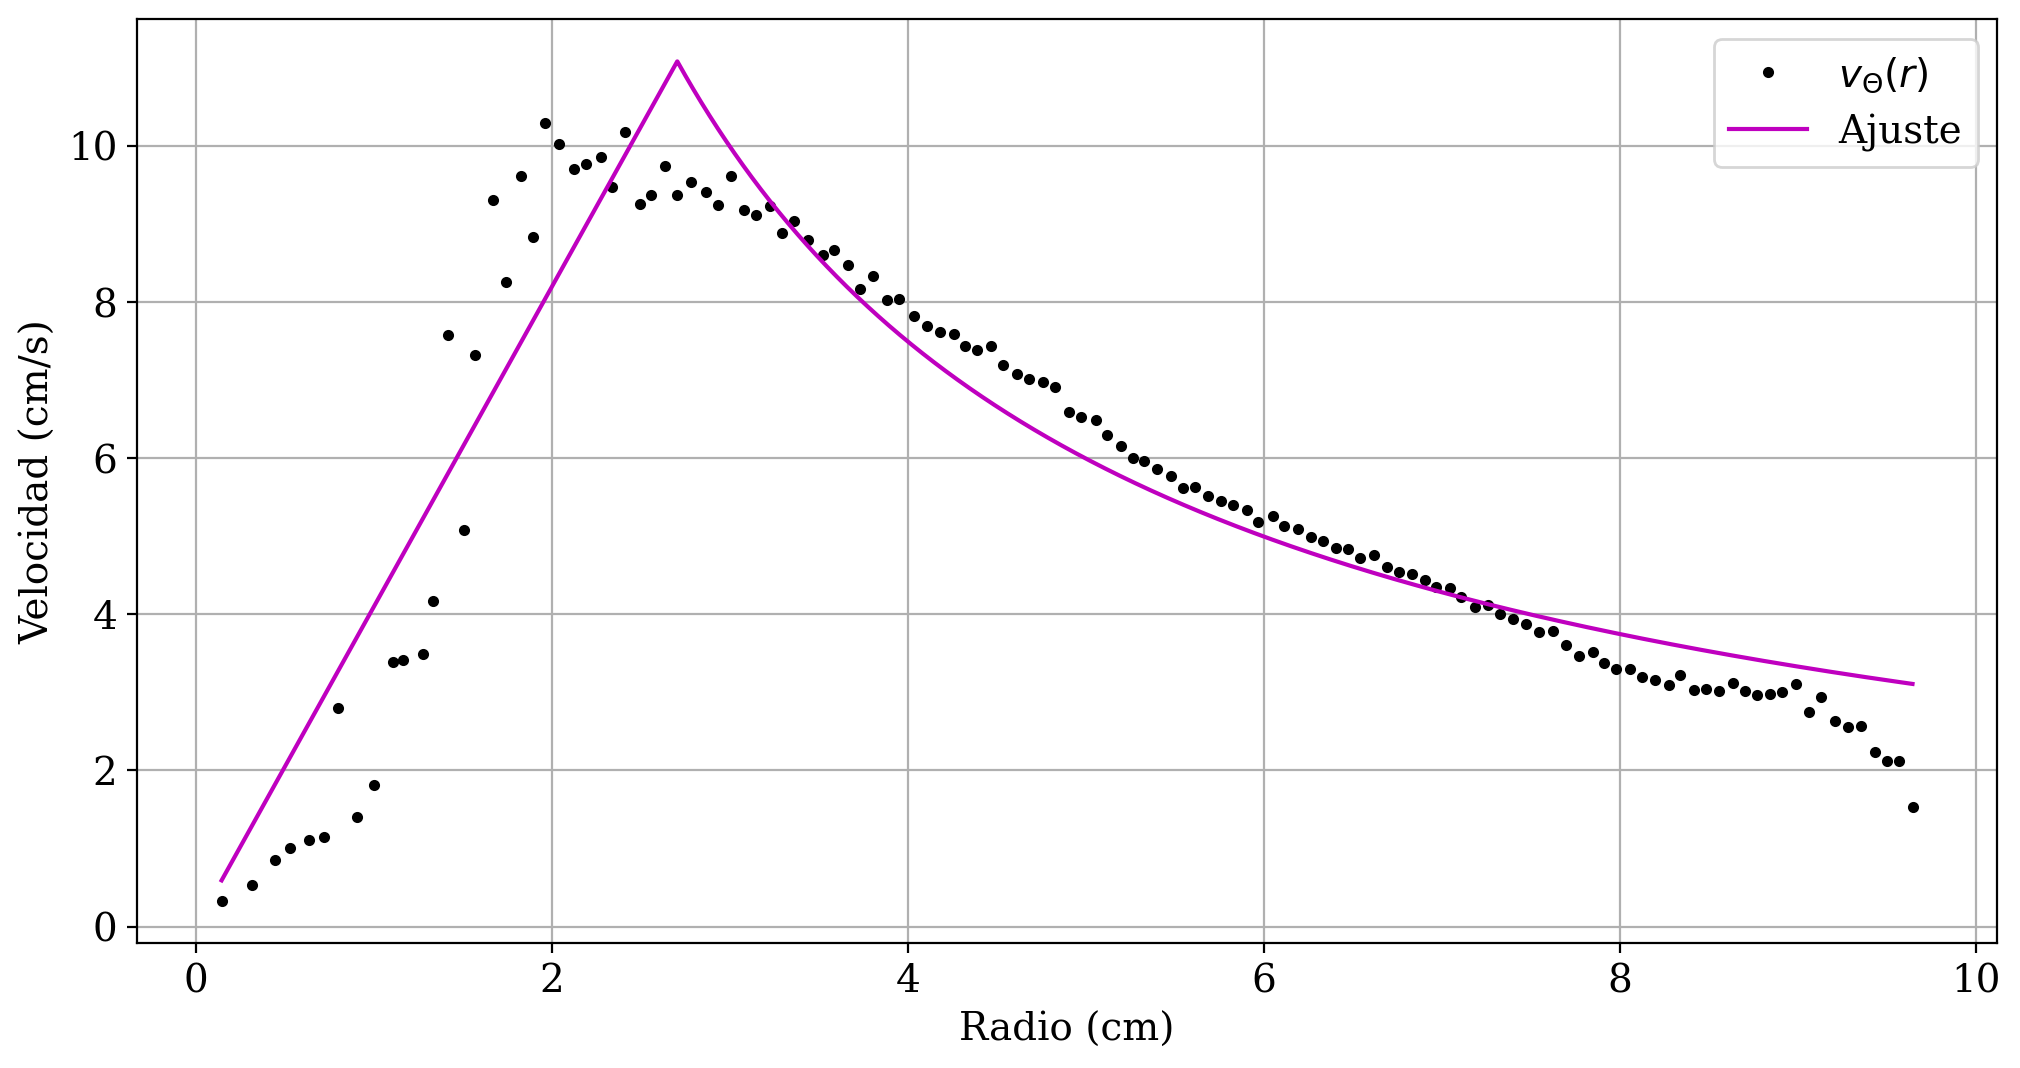

La velocidad angular Omega es 4.099 con error 0.086
El radio del vortice c es 2.704 con error 0.0344


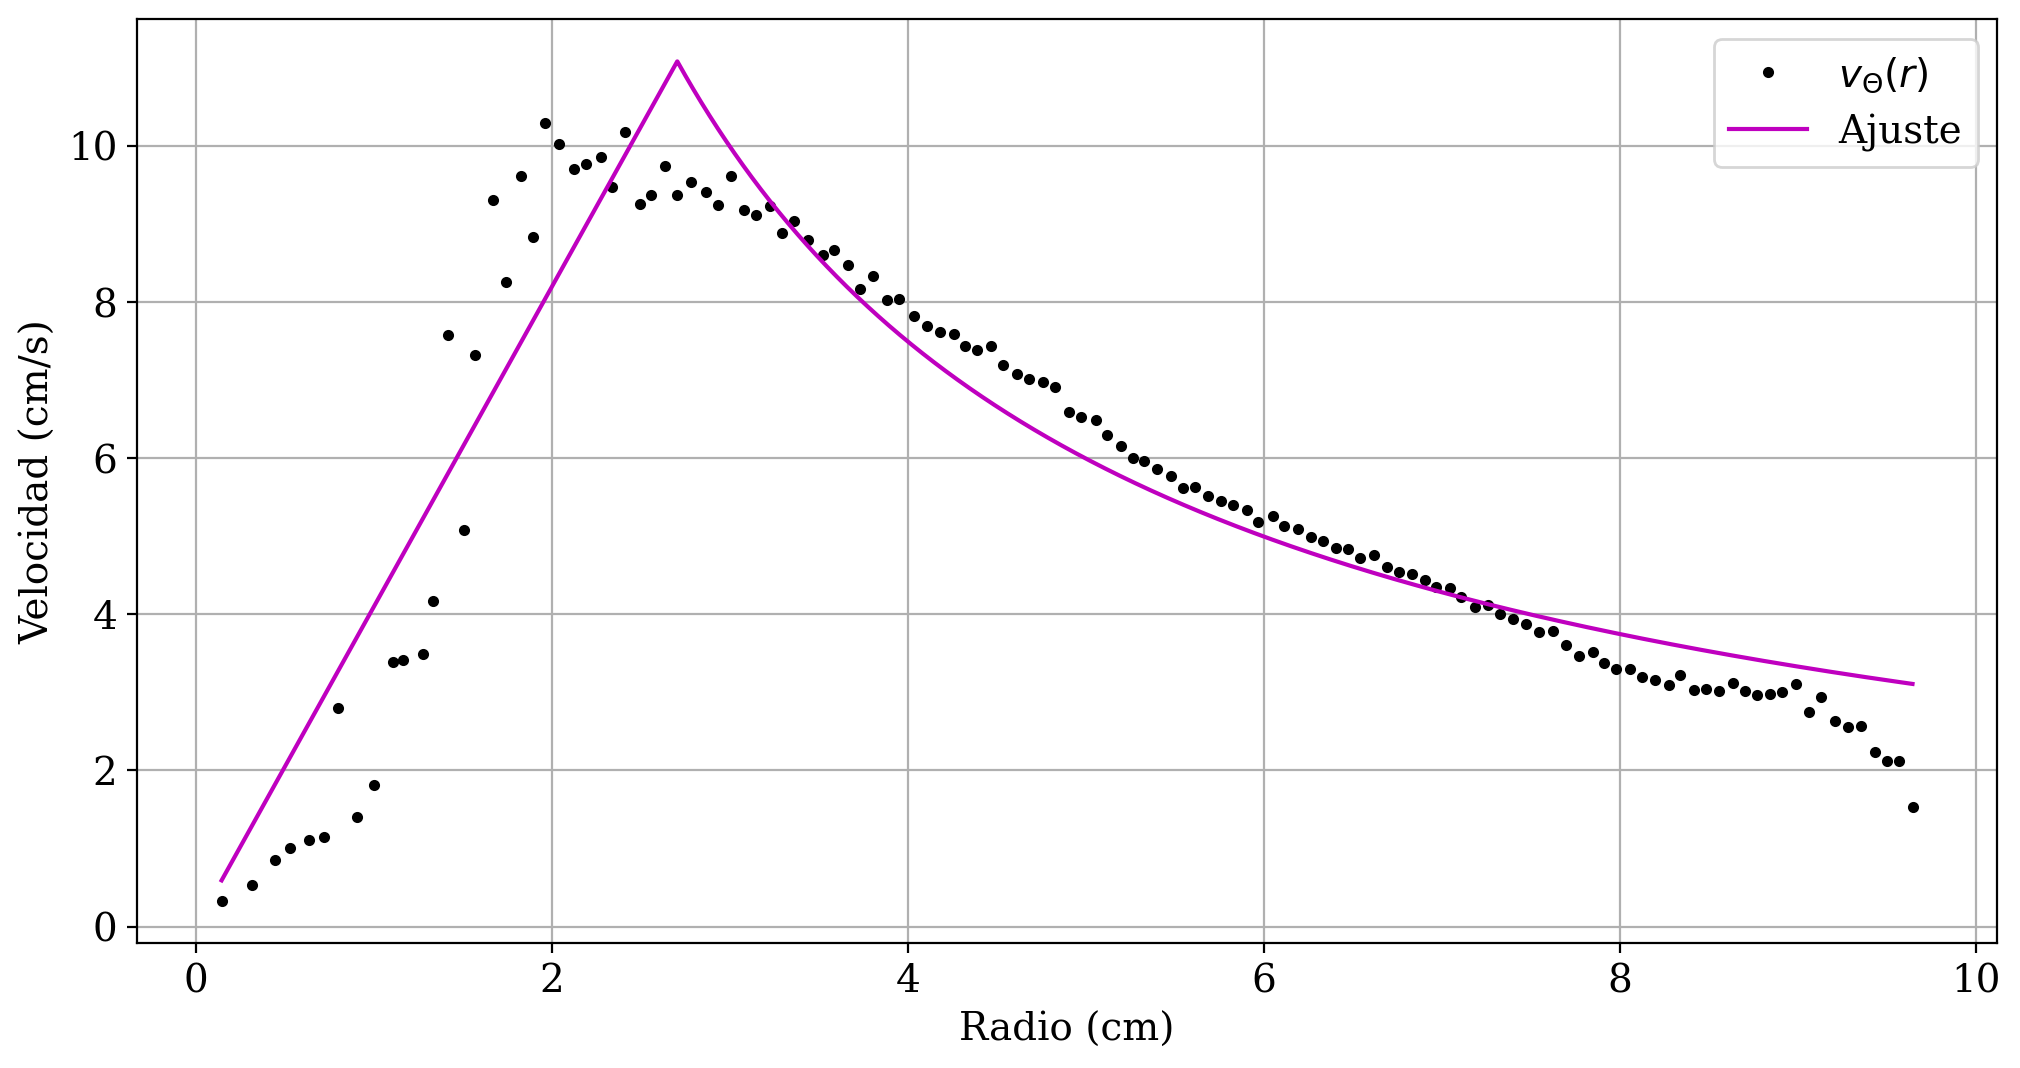

La velocidad angular Omega es 4.099 con error 0.086
El radio del vortice c es 2.704 con error 0.0344


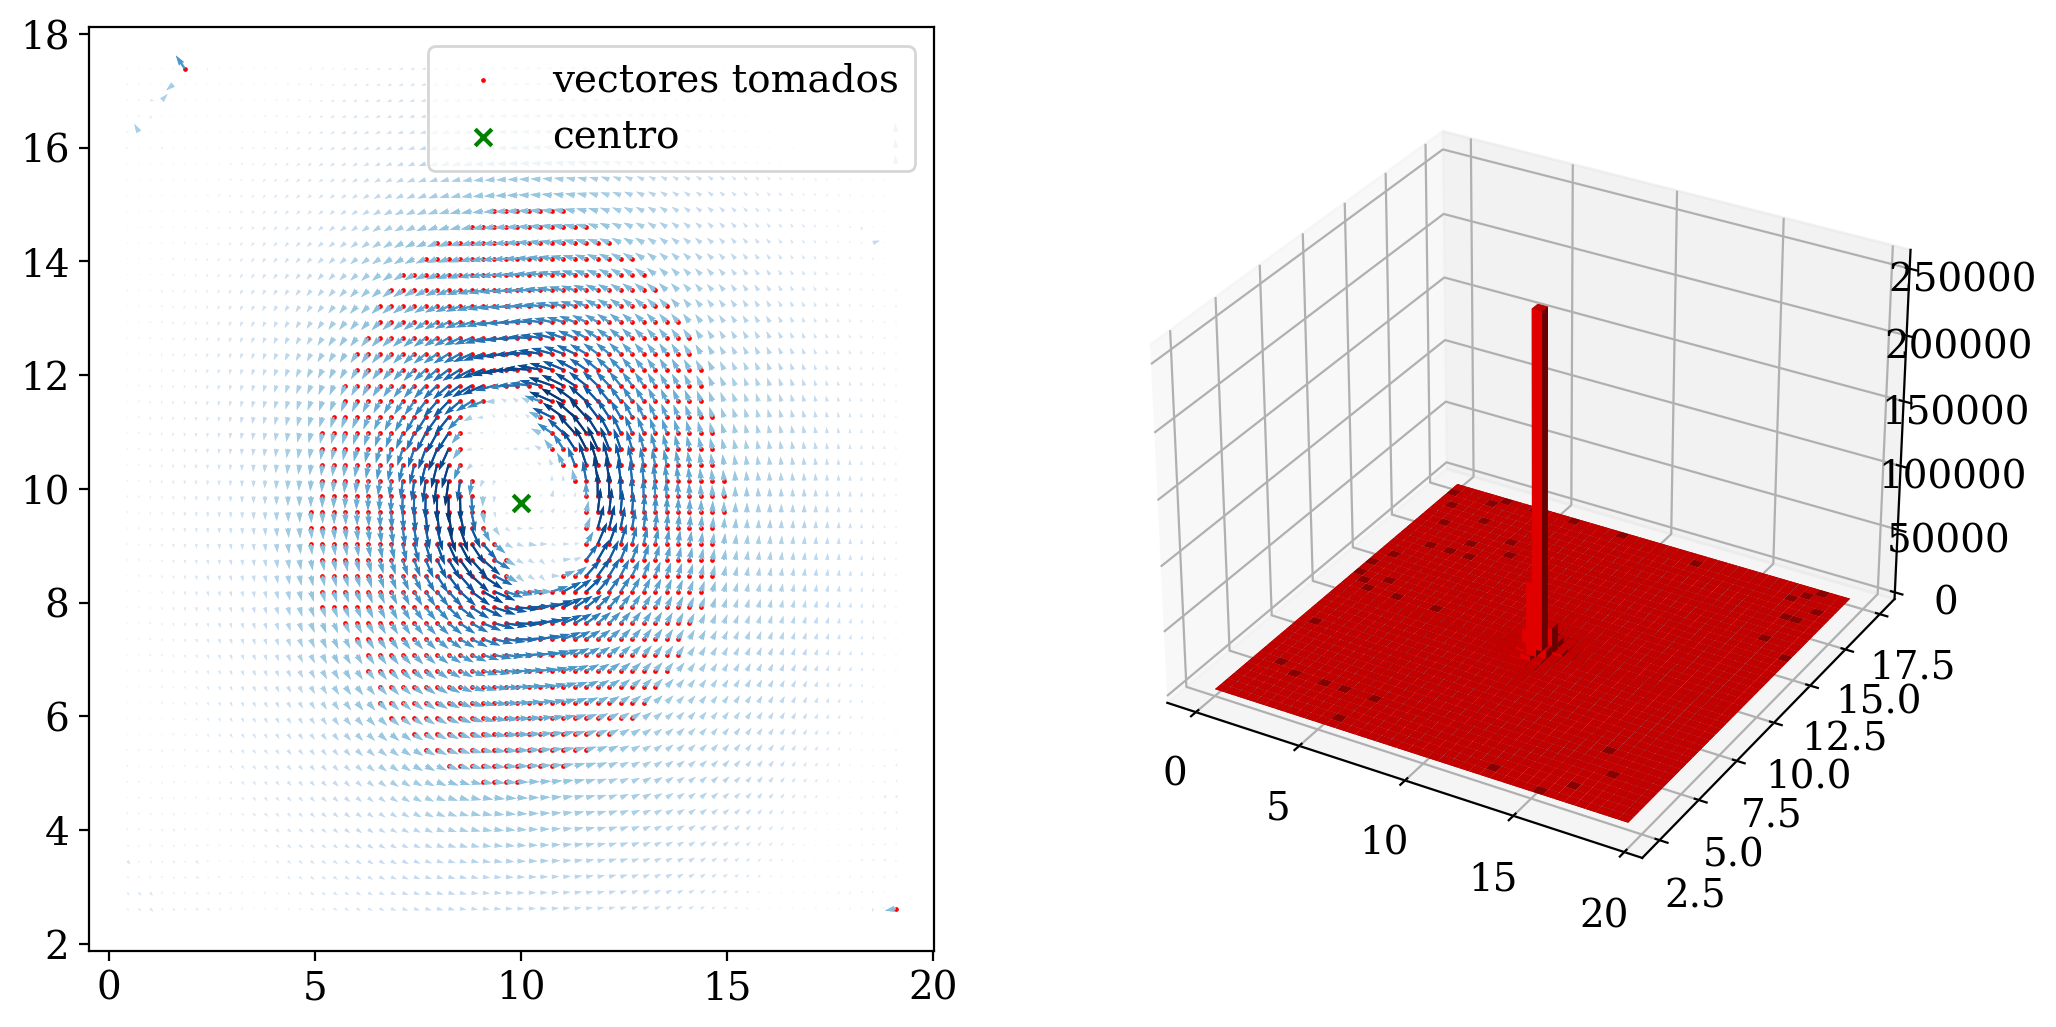

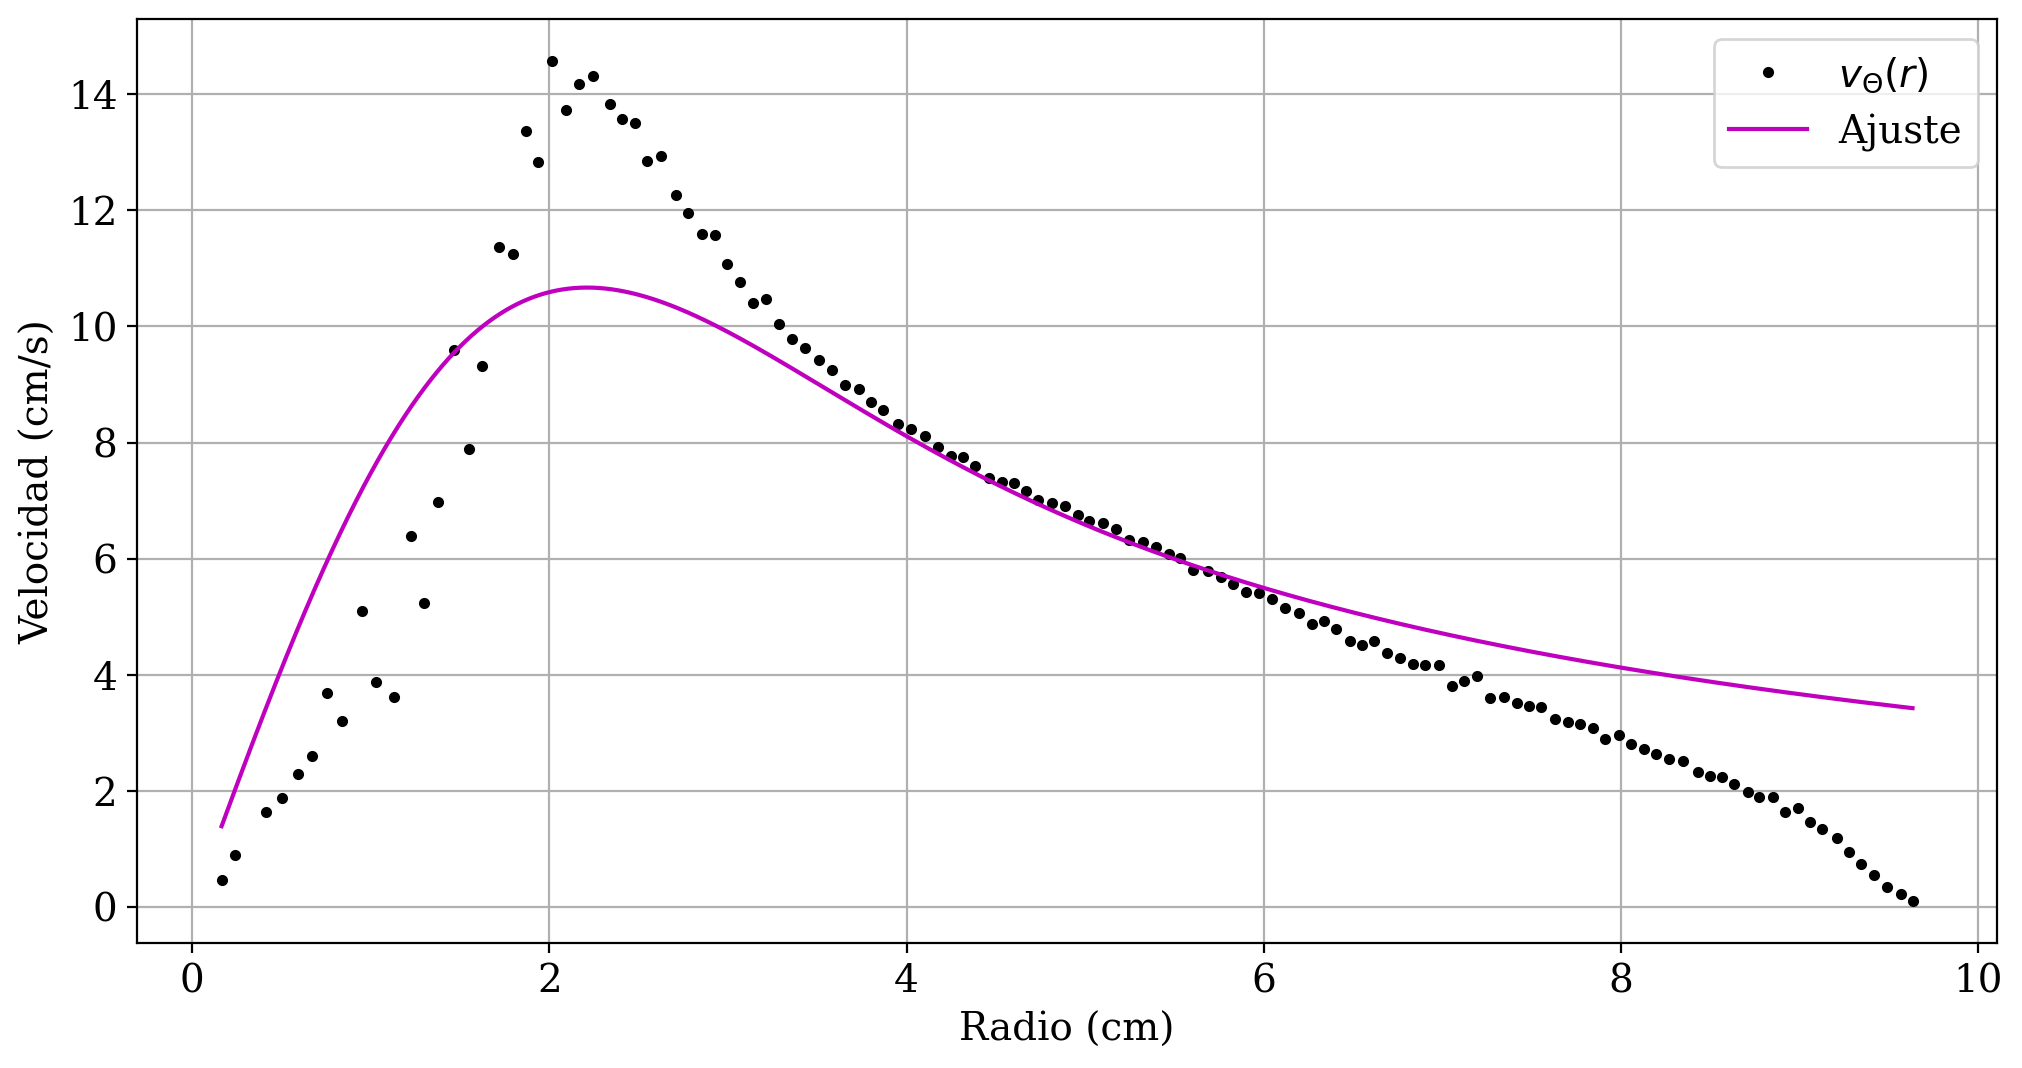

La velocidad angular Omega es 8.478 con error 0.678
El radio del vortice c es 1.972 con error 0.0728


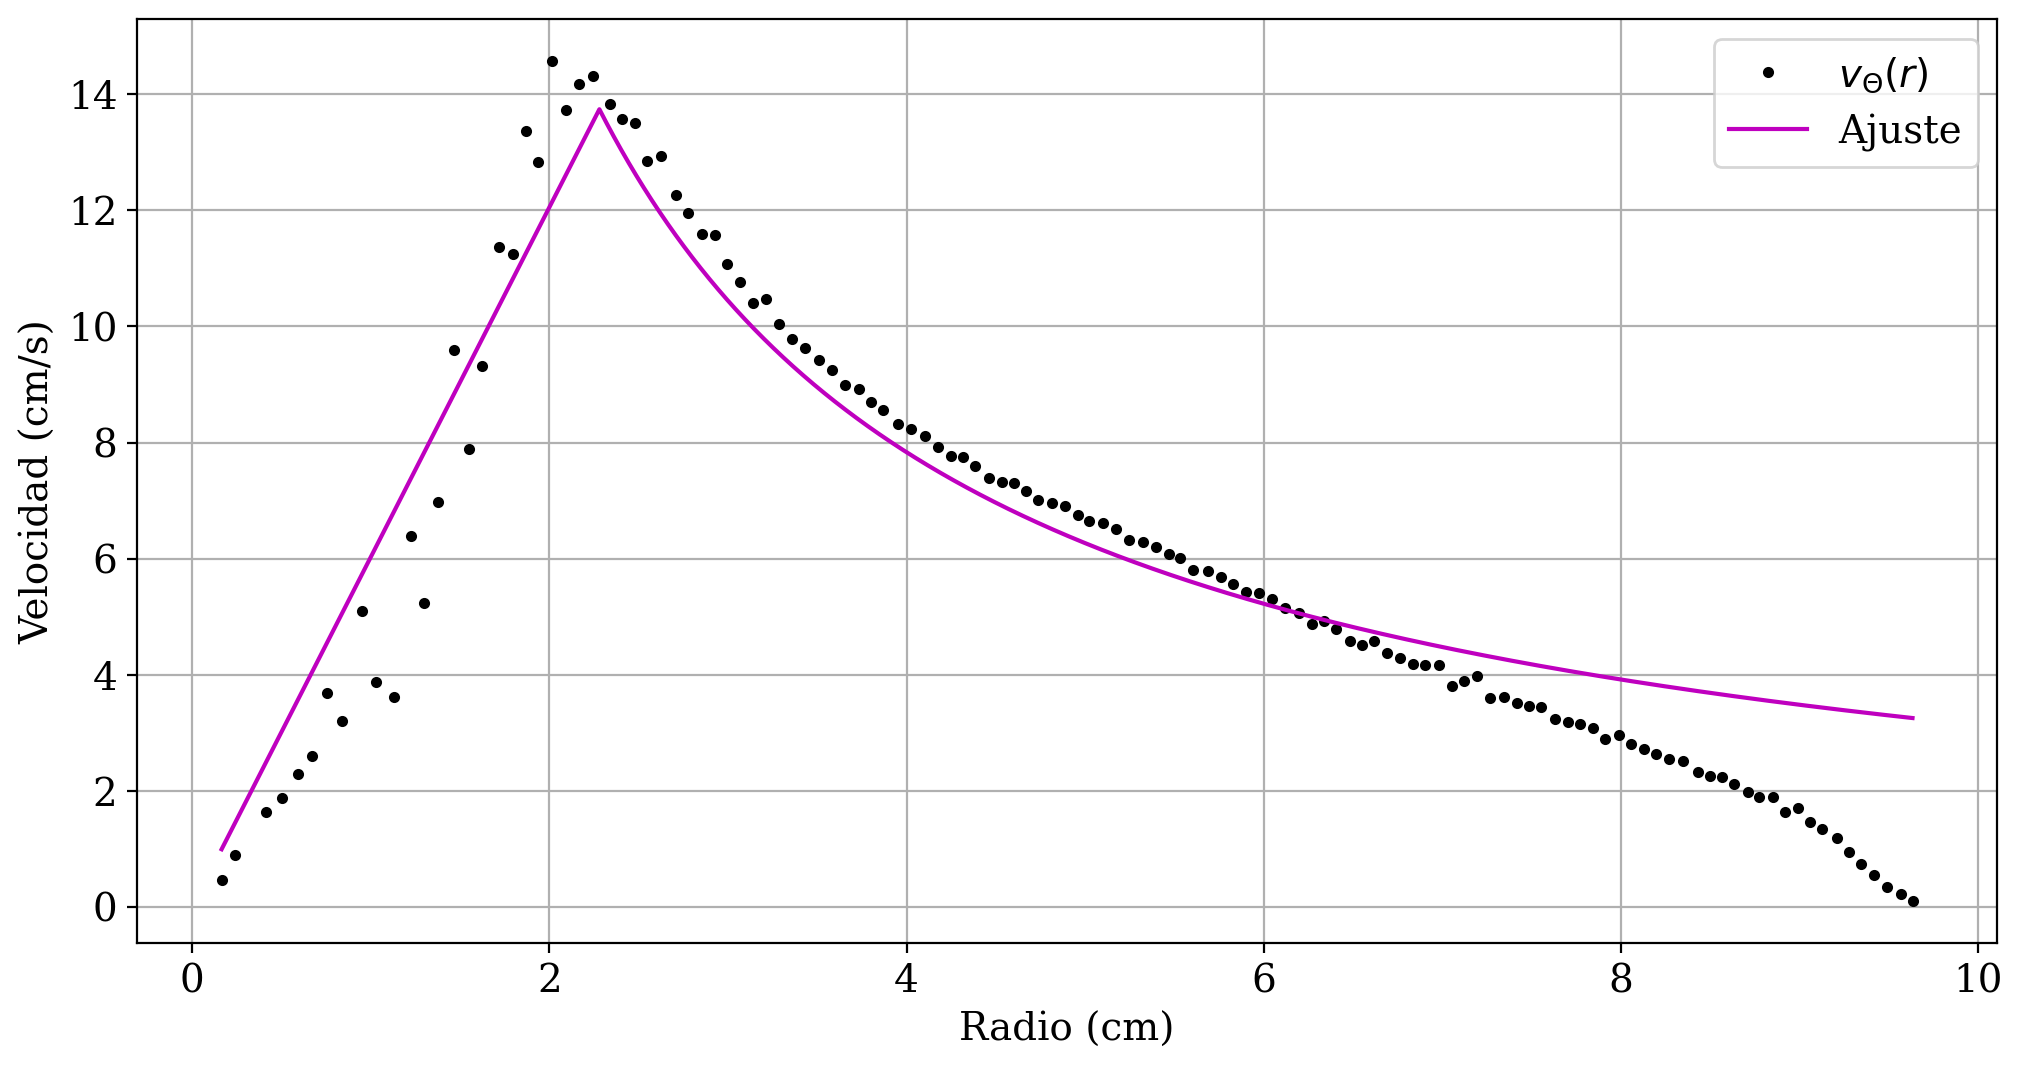

La velocidad angular Omega es 6.029 con error 0.165
El radio del vortice c es 2.28 con error 0.037


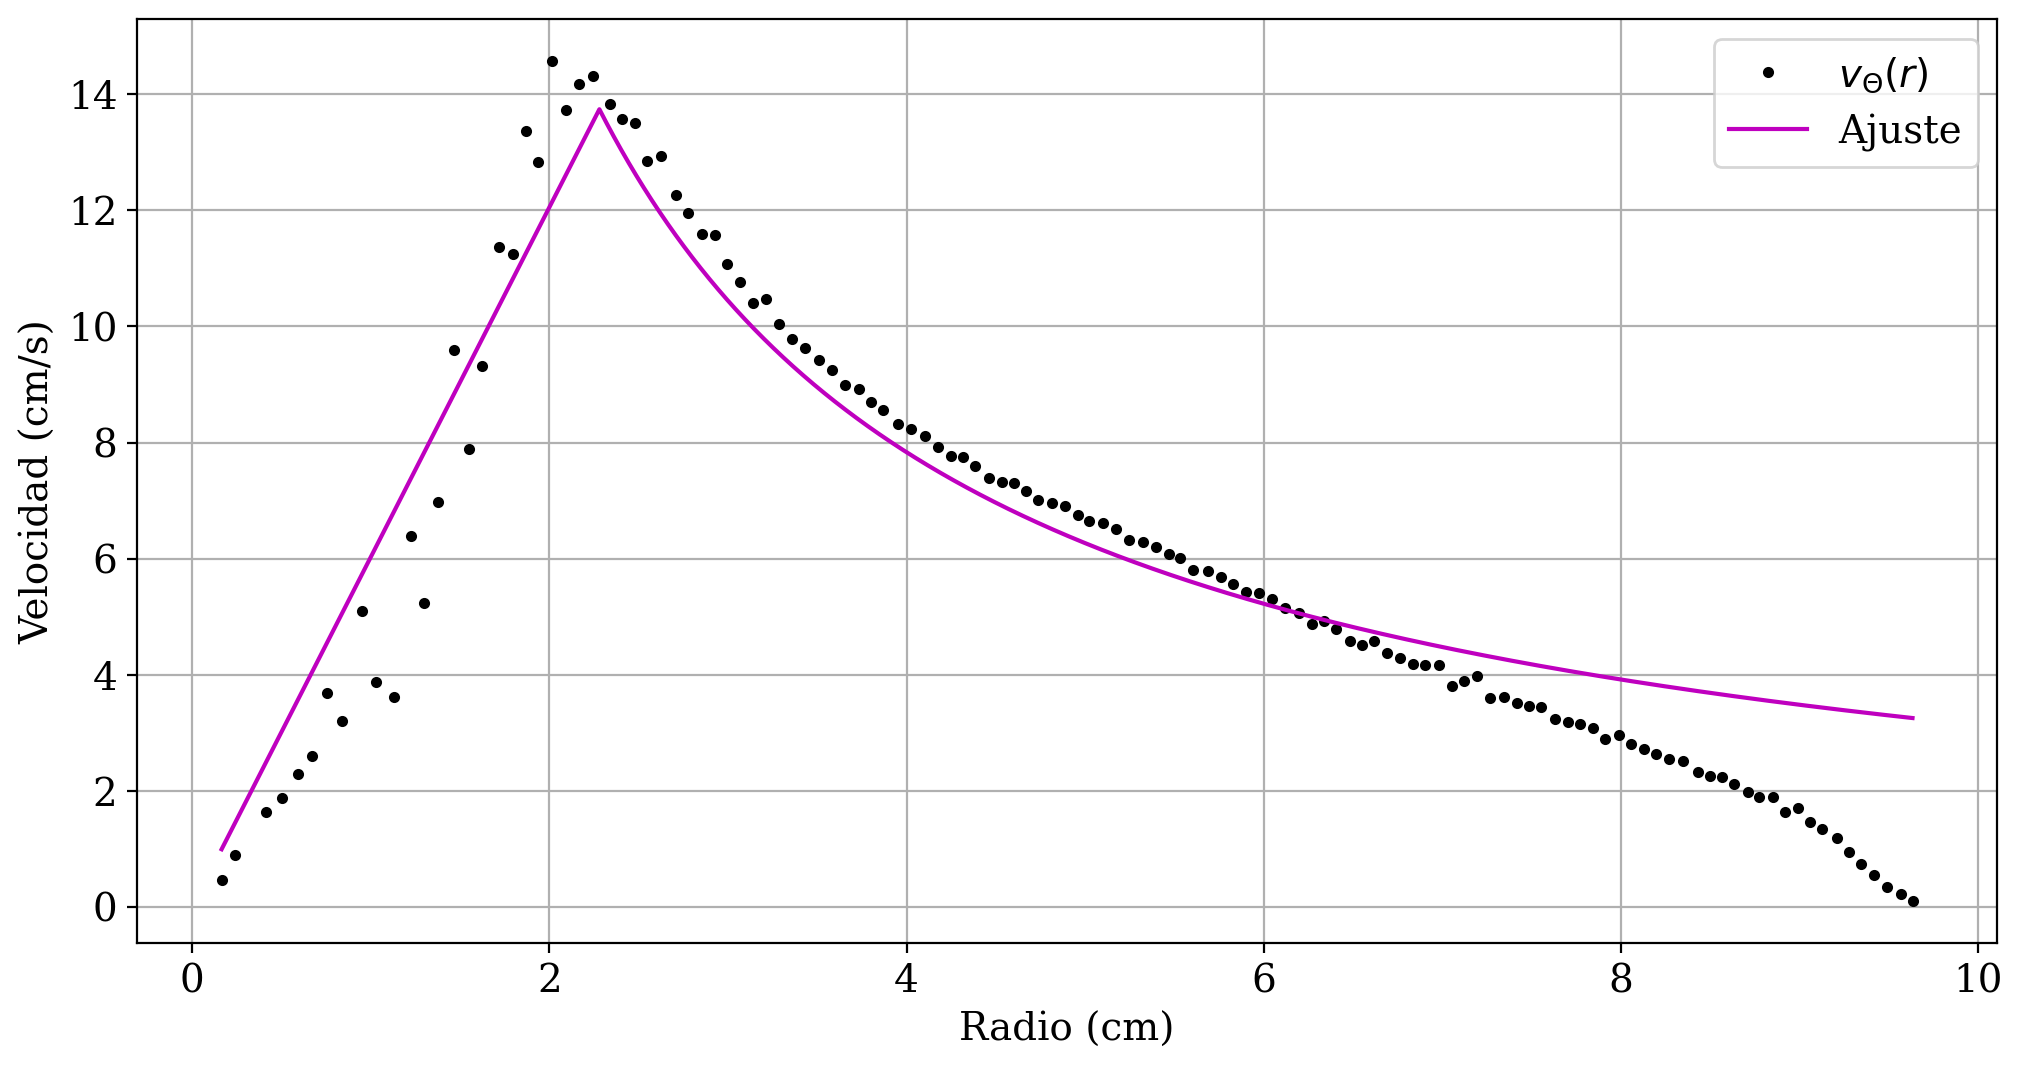

La velocidad angular Omega es 6.029 con error 0.165
El radio del vortice c es 2.28 con error 0.037


In [47]:
dir = "nuevas mediciones"
path_list = ["destilada lento dos filtros/destilada lento.npz", 
             "destilada medio dos filtros/destilada medio.npz", 
             "destilada rapido dos filtros/destilada rapido.npz",
             "glicerina 50 rapido dos filtros/glicerina 50 rapido.npz"]
for i in range(len(path_list)):
    find_center(dir+"/"+path_list[i], r_max=radio_recipiente, y_lims=[2.5,17.5], v_quantile=.75)

multiplicar funcion de ajuste por funcion sigmoide suave. tanh() por ej, exponencial por ahi.
estimar hasta donde no se aprecian efectos de borde.

opcion b. Ir variando el corte, y fijarse como varian los parametros.

Dividir errores por raiz de n.